In [1]:
import numpy as np
import pandas
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# create a client instance of the library
#elastic_client = Elasticsearch(timeout=60, max_retries=10, retry_on_timeout=True)
#elastic_client.cluster.health(wait_for_status='yellow', request_timeout=55)

In [2]:
import pickle
pickle_save_path = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\elastic_df.pkl'

In [3]:
with open(pickle_save_path,'rb') as path_name:
    elastic_df = pickle.load(path_name) 

In [5]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637325 entries, 0 to 645627
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   creator                  637325 non-null  object  
 1   sale_usd                 637325 non-null  float64 
 2   description              637325 non-null  object  
 3   is_animation             637325 non-null  bool    
 4   name                     637325 non-null  object  
 5   collection_name          637325 non-null  object  
 6   collection_description   637325 non-null  object  
 7   contract_scheme          637325 non-null  category
 8   sale_token               637325 non-null  object  
 9   id                       637325 non-null  object  
 10  instagram                637325 non-null  object  
 11  twitter                  637325 non-null  object  
 12  img_path                 637325 non-null  object  
 13  twitter_follower         637325 non-null  fl

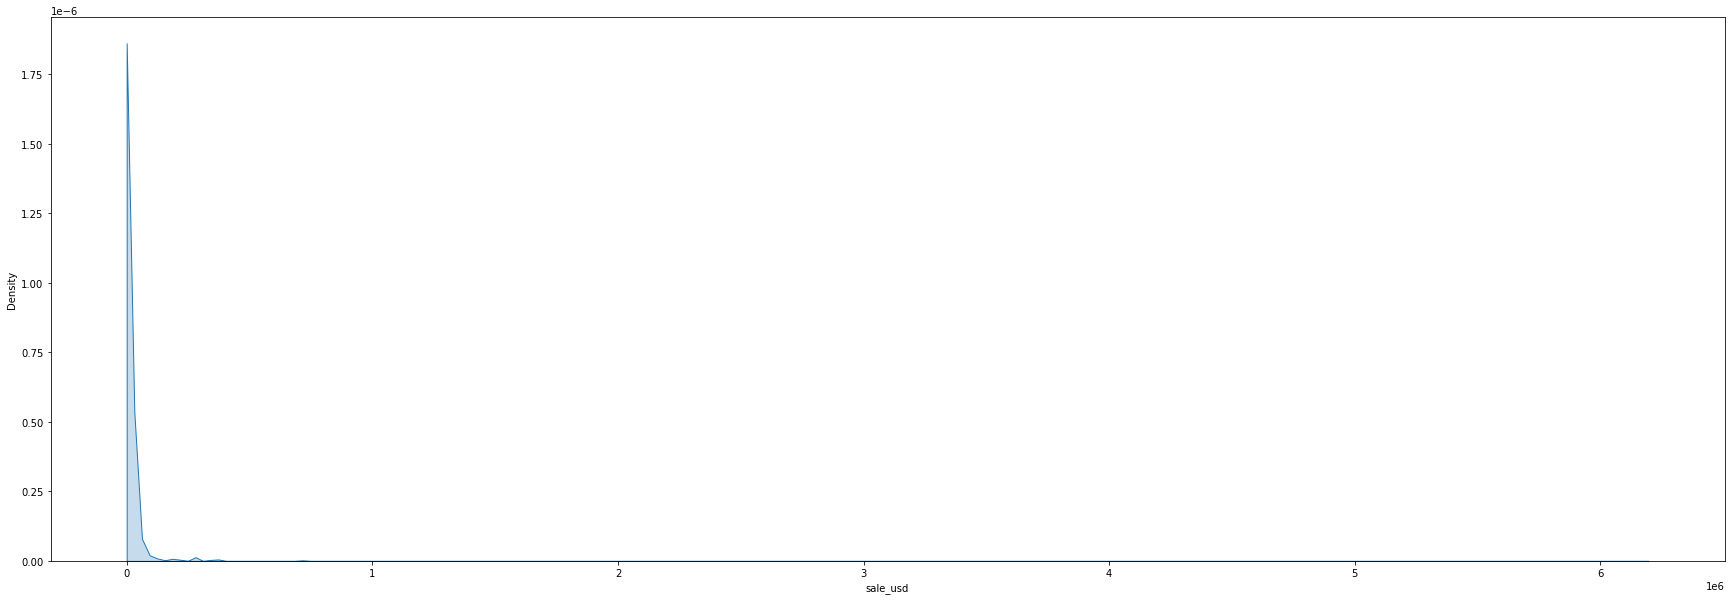

In [4]:
plt.figure(figsize = (30,10))
sns.kdeplot(elastic_df['sale_usd'], bw_method=0.01, fill = True)
plt.show()

## Sales feature

In [4]:
from scipy import stats 

In [7]:
elastic_df['sale_usd'].describe()

count    6.373250e+05
mean     2.117672e+03
std      1.653876e+04
min      3.161950e-15
25%      1.719355e+02
50%      3.958857e+02
75%      1.015681e+03
max      6.195956e+06
Name: sale_usd, dtype: float64

In [5]:
mean = np.mean(elastic_df['sale_usd'])
std = np.std(elastic_df['sale_usd'])
median = np.median(elastic_df['sale_usd'])
print('Mean of sales is', mean)
print('Std. deviation is', std)
print('Median is', median)

Mean of sales is 2117.6719524899927
Std. deviation is 16538.7512094513
Median is 395.8857


{'whiskers': [<matplotlib.lines.Line2D at 0x1cf55cbf9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cf55cbf340>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cf55cbfe20>],
 'medians': [<matplotlib.lines.Line2D at 0x1cf5228abe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cf5228a850>],
 'means': []}

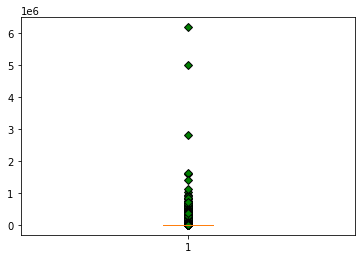

In [54]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.boxplot(elastic_df['sale_usd'], flierprops=green_diamond)

In [6]:
threshold = 3
outlier = []
for i in elastic_df['sale_usd']:
    z = (i-mean)/std
    if z > threshold:
        outlier.append(i)
len(outlier)        

2733

In [7]:
elastic_df = elastic_df[elastic_df['sale_usd'].apply(lambda usd: usd not in outlier)]

In [8]:
elastic_df = elastic_df.reset_index(drop=True)

## Y-bin

In [9]:
max_usd = np.max(elastic_df['sale_usd']) + 1 # added 1 because sometimes the max value was not bined
print(f'Max price: {max_usd}')

Max price: 51729.4664


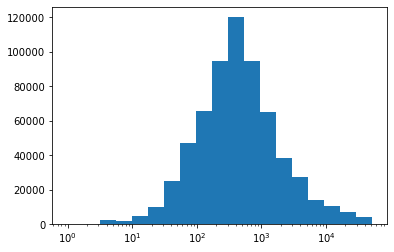

In [10]:
plt.hist(elastic_df['sale_usd'], bins = np.logspace(start = np.log10(1), stop = np.log10(max_usd), num = 20))
plt.gca().set_xscale("log")
plt.show()
# hbars = ax.barh(y_pos, performance, xerr=error, align='center')
# .bar_label(hbars, fmt='%.2f')

In [11]:
bins = np.logspace(start = np.log10(1), stop = np.log10(max_usd), num = 20)
bins

array([1.00000000e+00, 1.77048183e+00, 3.13460590e+00, 5.54976279e+00,
       9.82575417e+00, 1.73963192e+01, 3.07998670e+01, 5.45306049e+01,
       9.65454451e+01, 1.70931956e+02, 3.02631922e+02, 5.35804319e+02,
       9.48631810e+02, 1.67953538e+03, 2.97358687e+03, 5.26468152e+03,
       9.32102296e+03, 1.65027018e+04, 2.92177336e+04, 5.17294664e+04])

In [12]:
def bin_number(price):
    for i in range(0, len(bins)):
        start = 0
        if i > 0:
            start = bins[i-1]
        end = bins[i]
        if price > start and price <= end:
            return int(i) 
        
elastic_df['bin_log_usd'] = elastic_df['sale_usd'].apply(bin_number)

In [13]:
bin_labels = []
for i in range(0, len(bins)):
    start = 0
    if i > 0:
        start = bins[i-1]
    end = bins[i]
    s = '{:.1f}'.format(start)
    e = '{:.1f}'.format(end)
    bin_labels.append(f'{s}-{e}')
bin_labels
# restart for ResNet
# Step 2

['0.0-1.0',
 '1.0-1.8',
 '1.8-3.1',
 '3.1-5.5',
 '5.5-9.8',
 '9.8-17.4',
 '17.4-30.8',
 '30.8-54.5',
 '54.5-96.5',
 '96.5-170.9',
 '170.9-302.6',
 '302.6-535.8',
 '535.8-948.6',
 '948.6-1679.5',
 '1679.5-2973.6',
 '2973.6-5264.7',
 '5264.7-9321.0',
 '9321.0-16502.7',
 '16502.7-29217.7',
 '29217.7-51729.5']

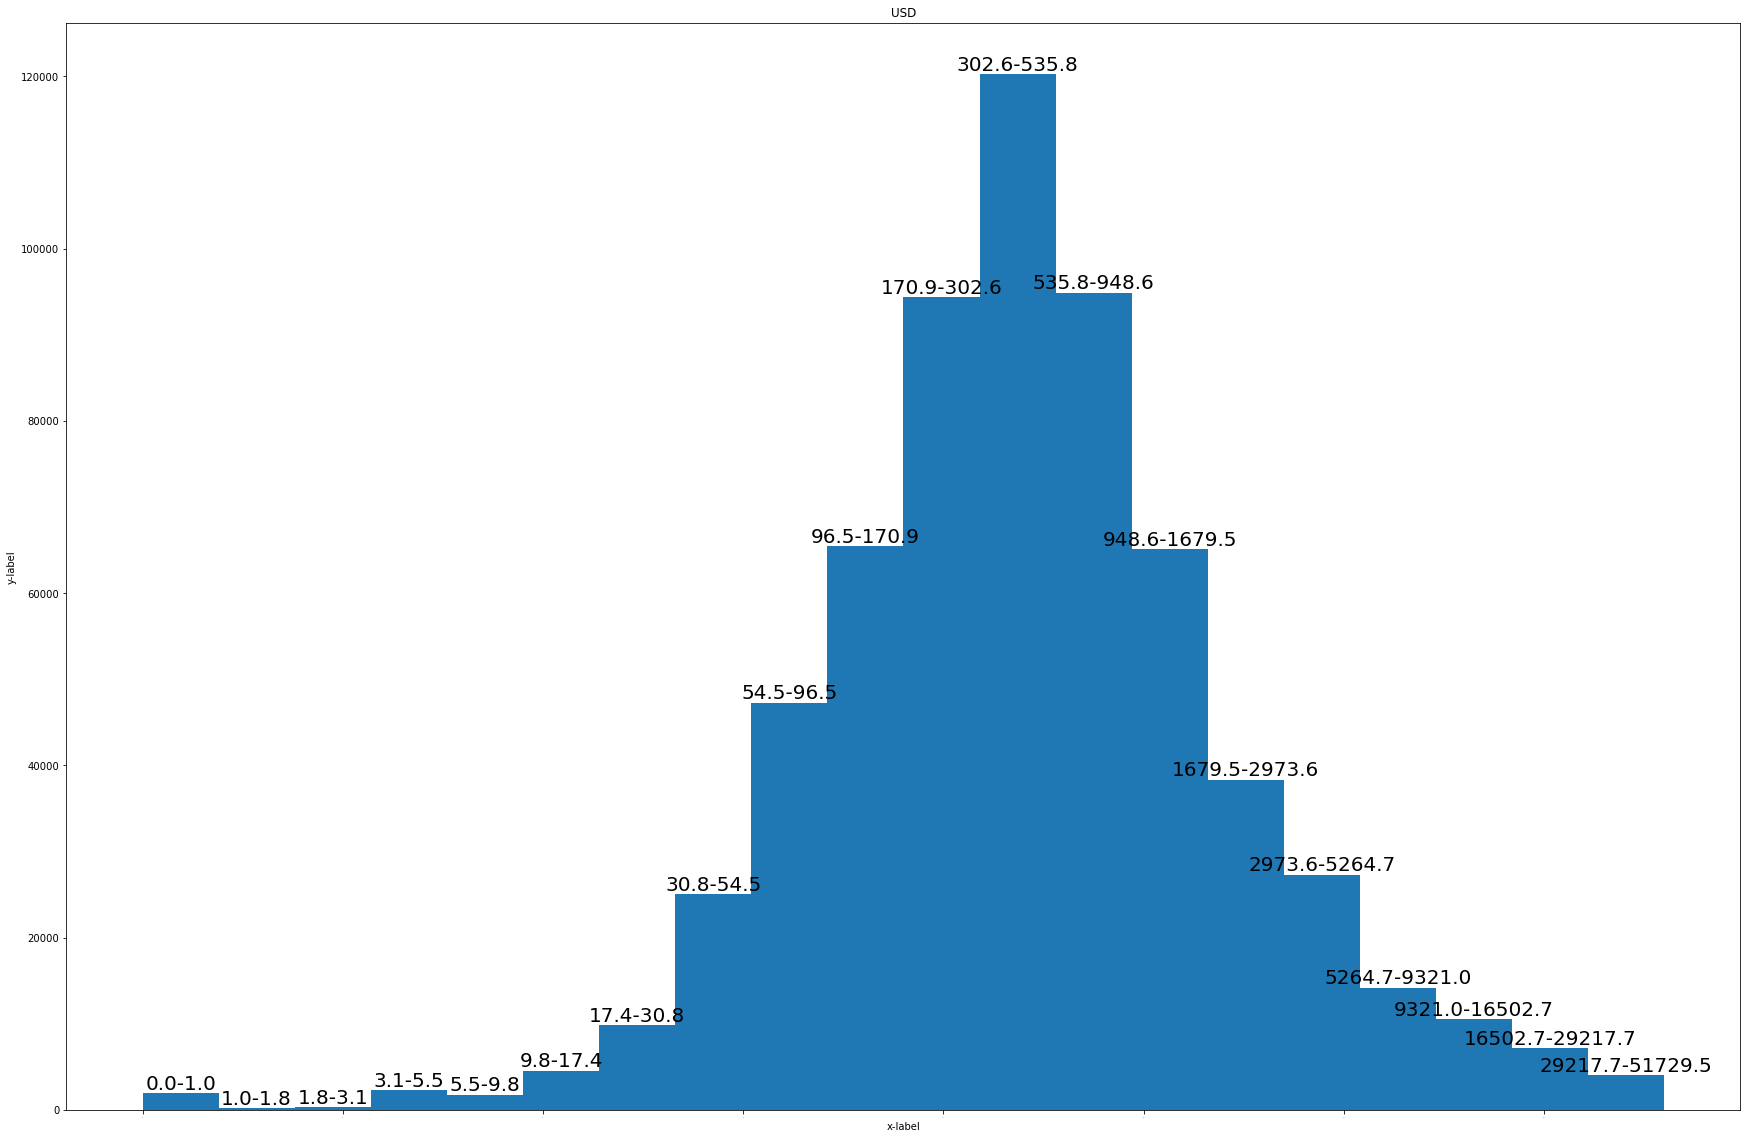

In [14]:
# Creating histogram
fig, ax = plt.subplots(1, 1, figsize=(30,20))
ax.hist(elastic_df['bin_log_usd'], bins=len(bin_labels), align='mid')
# Set title
ax.set_title("USD")
# adding labels
ax.set_xlabel('x-label')
ax.set_ylabel('y-label')
# Make some labels.

#range(len(bin_labels)
rects = ax.patches
for rect, label in zip(rects, bin_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=20)
plt.xticks(fontsize=0)
# Show plot
plt.show()

In [15]:
elastic_df['cat_usd'] = elastic_df['bin_log_usd'].astype('category')

In [16]:
len(elastic_df['cat_usd'].cat.categories)

20

In [17]:
idx_to_class = {
    idx: class_
    for idx, class_ in enumerate(bin_labels)
}
class_to_idx = {bin_labels[i]: i for i in range(len(bin_labels))}

class_to_idx
# Restart for ResNet
# Step 3

{'0.0-1.0': 0,
 '1.0-1.8': 1,
 '1.8-3.1': 2,
 '3.1-5.5': 3,
 '5.5-9.8': 4,
 '9.8-17.4': 5,
 '17.4-30.8': 6,
 '30.8-54.5': 7,
 '54.5-96.5': 8,
 '96.5-170.9': 9,
 '170.9-302.6': 10,
 '302.6-535.8': 11,
 '535.8-948.6': 12,
 '948.6-1679.5': 13,
 '1679.5-2973.6': 14,
 '2973.6-5264.7': 15,
 '5264.7-9321.0': 16,
 '9321.0-16502.7': 17,
 '16502.7-29217.7': 18,
 '29217.7-51729.5': 19}

## Split the data

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [20]:
dummies_contract = pandas.get_dummies(elastic_df.contract_scheme, prefix = 'contract_scheme')

In [22]:
elastic_df['contract_scheme'].value_counts()

1    579712
2     54880
3         0
Name: contract_scheme, dtype: int64

In [21]:
elastic_df['contract_scheme_1'] = dummies_contract['contract_scheme_1']
elastic_df['contract_scheme_2'] = dummies_contract['contract_scheme_2']
elastic_df['contract_scheme_3'] = dummies_contract['contract_scheme_3']

In [64]:
elastic_df.keys()

Index(['creator', 'sale_usd', 'description', 'is_animation', 'name',
       'collection_name', 'collection_description', 'contract_scheme',
       'sale_token', 'id', 'instagram', 'twitter', 'img_path',
       'twitter_follower', 'preview_path', 'sale_time',
       'collection_created_year', 'unique_asset', 'instagram_account',
       'twitter_account', 'name_tok', 'creator_tok', 'collection_name_tok',
       'instagram_tok', 'twitter_tok', 'word_count_coll_desc',
       'word_count_descr', 'bin_log_usd', 'cat_usd', 'z_twitter_follower',
       'contract_scheme_1', 'contract_scheme_2', 'contract_scheme_3'],
      dtype='object')

In [65]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634592 entries, 0 to 634591
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   creator                  634592 non-null  object  
 1   sale_usd                 634592 non-null  float64 
 2   description              634592 non-null  object  
 3   is_animation             634592 non-null  bool    
 4   name                     634592 non-null  object  
 5   collection_name          634592 non-null  object  
 6   collection_description   634592 non-null  object  
 7   contract_scheme          634592 non-null  category
 8   sale_token               634592 non-null  object  
 9   id                       634592 non-null  object  
 10  instagram                634592 non-null  object  
 11  twitter                  634592 non-null  object  
 12  img_path                 634592 non-null  object  
 13  twitter_follower         634592 non-null  fl

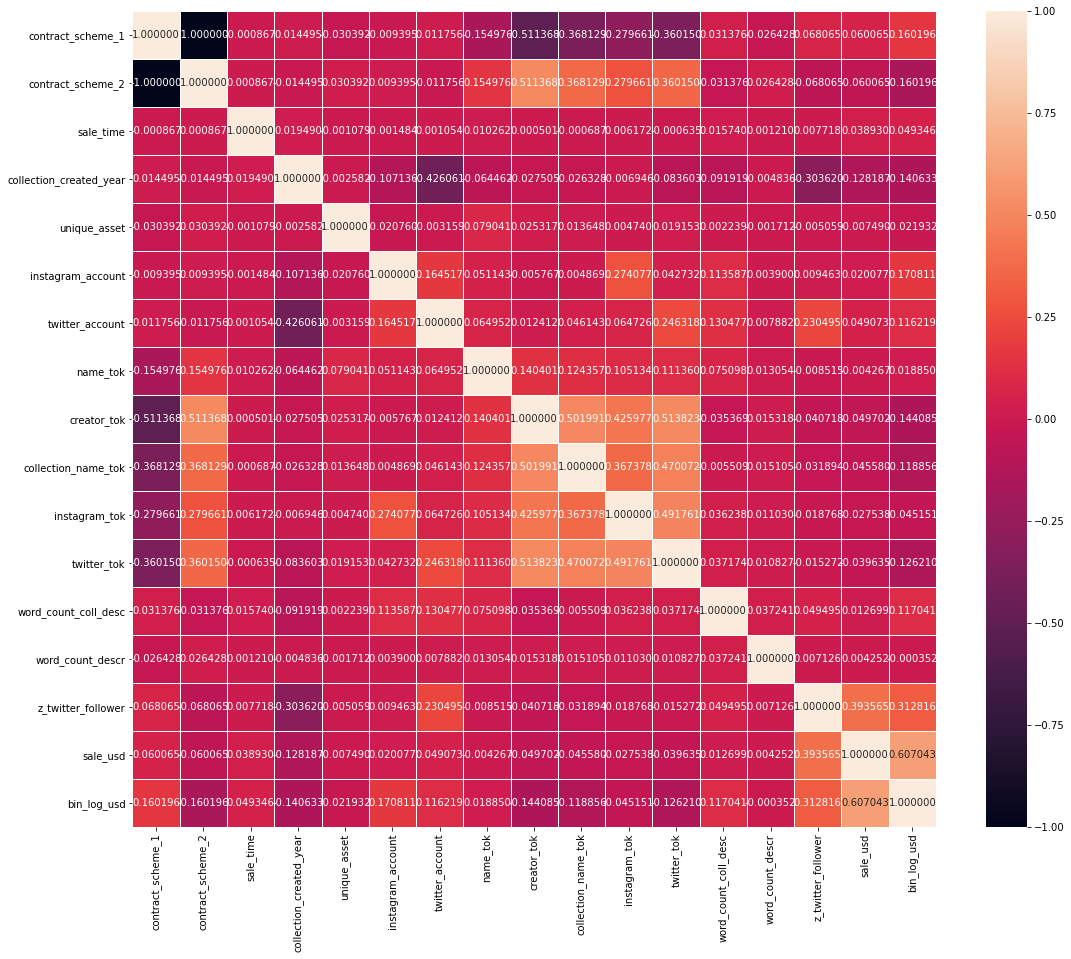

In [69]:
corr= elastic_df[['contract_scheme_1', 'contract_scheme_2',  
                'sale_time', 'collection_created_year', 'unique_asset', 'instagram_account',
                'twitter_account', 'name_tok', 'creator_tok', 'collection_name_tok', 'instagram_tok', 
                'twitter_tok',
                'word_count_coll_desc', 'word_count_descr', 'z_twitter_follower', 'sale_usd', 'bin_log_usd']].corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f');
# 'contract_scheme_3',

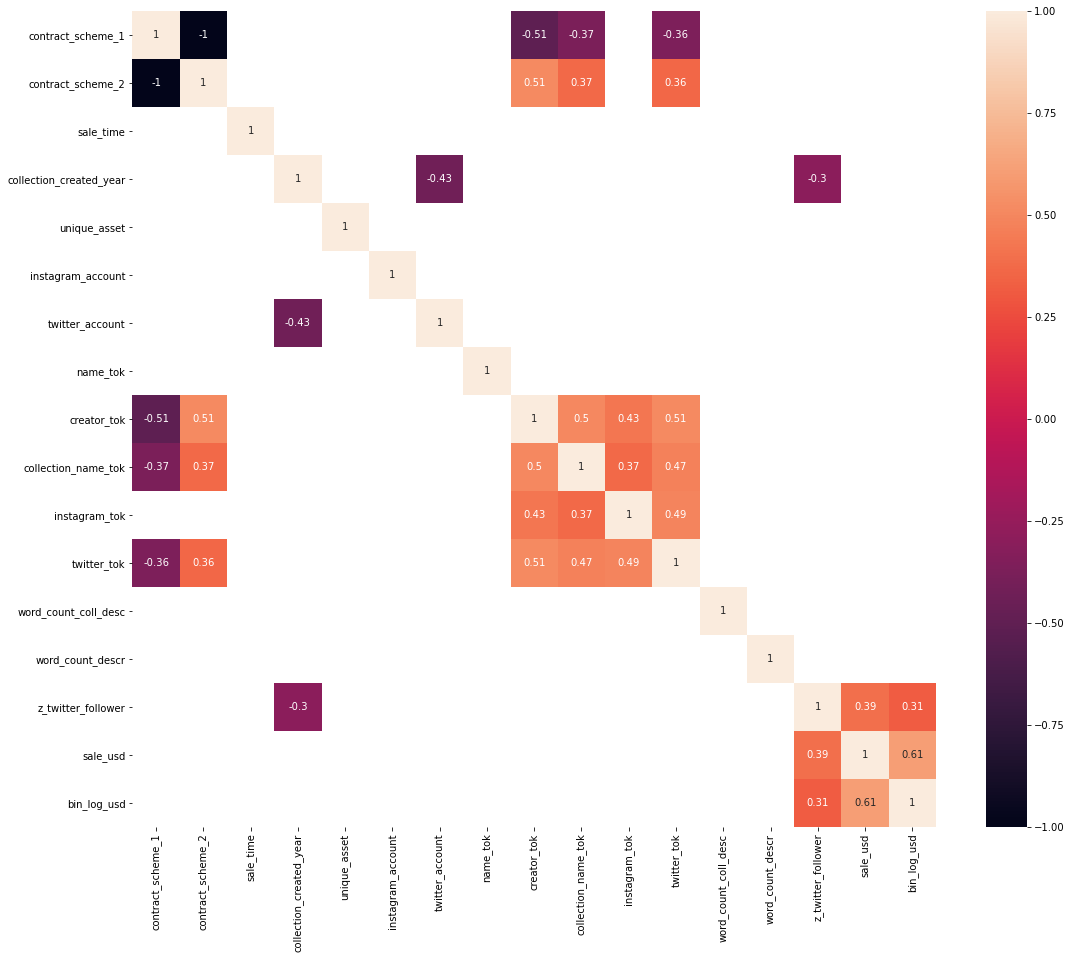

In [70]:
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],
            annot=True);

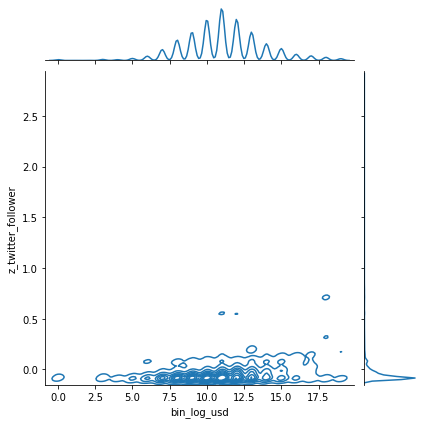

In [71]:
sns.jointplot(x='bin_log_usd',y='z_twitter_follower',data=elastic_df, kind='kde')

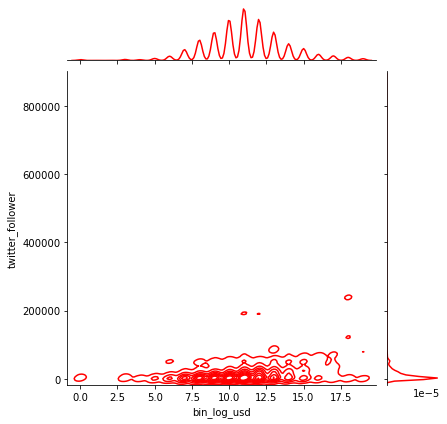

In [72]:
sns.jointplot(x='bin_log_usd',y='twitter_follower',data=elastic_df, color='red', kind='kde')

In [73]:
max(elastic_df['sale_usd'])

51728.4664

In [74]:
elastic_df[elastic_df['sale_usd'] == 51728.4664]

,creator,sale_usd,description,is_animation,name,collection_name,collection_description,contract_scheme,sale_token,id,...,instagram_tok,twitter_tok,word_count_coll_desc,word_count_descr,bin_log_usd,cat_usd,z_twitter_follower,contract_scheme_1,contract_scheme_2,contract_scheme_3
225258,MutantApeYachtClub,51728.4664,"[mutant, ape, yacht, club, collection, mutant,...",False,,mutant-ape-yacht-club,"[mutant, ape, yacht, club, collection, mutant,...",1,ETH,eOPlF34BOa5kXuiNZG3j,...,0,0,41,41,19,19,-0.091952,1,0,0


In [81]:
from picklemultidataset import get_preview_image


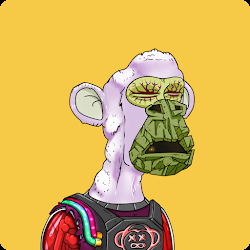

In [79]:
get_preview_image(elastic_df.loc[225258])

In [82]:
elastic_df[elastic_df['cat_usd'] == 19]

,creator,sale_usd,description,is_animation,name,collection_name,collection_description,contract_scheme,sale_token,id,...,instagram_tok,twitter_tok,word_count_coll_desc,word_count_descr,bin_log_usd,cat_usd,z_twitter_follower,contract_scheme_1,contract_scheme_2,contract_scheme_3
14,0x9056d15c49b19df52ffad1e6c11627f035c0c960,31322.3532,"[mutant, ape, yacht, club, collection, mutant,...",False,,mutant-ape-yacht-club,"[mutant, ape, yacht, club, collection, mutant,...",1,ETH,fOlO5X0Bt_K6OZC-xYcv,...,0,0,41,41,19,19,-0.091952,1,0,0
63,0x9056d15c49b19df52ffad1e6c11627f035c0c960,45653.6200,"[mutant, ape, yacht, club, collection, mutant,...",False,,mutant-ape-yacht-club,"[mutant, ape, yacht, club, collection, mutant,...",1,ETH,8elj5X0Bt_K6OZC-K5ta,...,0,0,41,41,19,19,-0.091952,1,0,0
126,0x9056d15c49b19df52ffad1e6c11627f035c0c960,30171.0880,"[mutant, ape, yacht, club, collection, mutant,...",False,,mutant-ape-yacht-club,"[mutant, ape, yacht, club, collection, mutant,...",1,ETH,0ul35X0Bt_K6OZC-Rq71,...,0,0,41,41,19,19,-0.091952,1,0,0
238,RTFKTCloneXVial,31719.3412,"[clone, x, next, gen, avatar, rtfkt, takashi, ...",False,CloneX #11331,clonex,"[clone, x, next, gen, avatar, rtfkt, takashi, ...",1,ETH,delm5X0Bt_K6OZC-YZ7Z,...,53,73,13,50,19,19,0.660714,1,0,0
293,0x9056d15c49b19df52ffad1e6c11627f035c0c960,31058.1960,"[mutant, ape, yacht, club, collection, mutant,...",False,,mutant-ape-yacht-club,"[mutant, ape, yacht, club, collection, mutant,...",1,ETH,PemC5X0Bt_K6OZC-obge,...,0,0,41,41,19,19,-0.091952,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631887,0x6f71e19e8b28963dfdfed04c4e6a217f0838aef2,34181.4240,"[vox, unique, collectible, provably, randomize...",False,Halfling - Longsong VOX #1852,collectvoxmirandus,"[meet, vox, adorable, collectible, series, gal...",1,ETH,B1lfY34B3CmUIj-JgJvK,...,80,90,28,18,19,19,0.833180,1,0,0
632194,Doodles_LLC,41170.8520,"[community, drive, collectible, project, featu...",False,Doodle #6670,doodles-official,"[community, drive, collectible, project, featu...",1,ETH,9lnrYn4B3CmUIj-JSxjS,...,0,66,46,63,19,19,0.457686,1,0,0
633302,MutantApeYachtClub,48143.3350,"[mutant, ape, yacht, club, collection, mutant,...",False,,mutant-ape-yacht-club,"[mutant, ape, yacht, club, collection, mutant,...",1,ETH,SFkzY34B3CmUIj-Jgmdx,...,0,0,41,41,19,19,-0.091952,1,0,0
634127,WorldofWomen,31259.9970,"[world, woman, unique, cool, diverse, woman, l...",False,Woman #2810,world-of-women-nft,"[community, celebrate, representation, inclusi...",1,ETH,DVr-Y34B3CmUIj-JJFye,...,0,82,34,13,19,19,0.195116,1,0,0


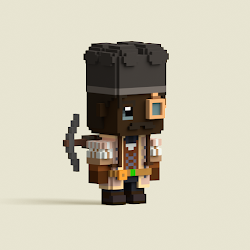

In [83]:
get_preview_image(elastic_df.loc[631887])

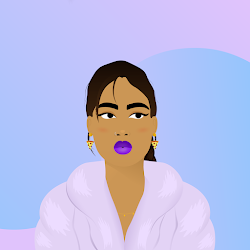

In [84]:
get_preview_image(elastic_df.loc[634127])

In [85]:
elastic_df[elastic_df['sale_usd'] == min(elastic_df['sale_usd'])] 

,creator,sale_usd,description,is_animation,name,collection_name,collection_description,contract_scheme,sale_token,id,...,instagram_tok,twitter_tok,word_count_coll_desc,word_count_descr,bin_log_usd,cat_usd,z_twitter_follower,contract_scheme_1,contract_scheme_2,contract_scheme_3
476027,0x66a2eb90e6a0cf9a53861b51f1c2041d5b1f8528,3.161950e-15,[phunkydoodles],False,#1687,phunkydoodles,"[phunkydoodles, randomly, generate, doodle, ro...",1,ETH,M2a2QX4BklRAyF0Rmdt-,...,0,0,12,1,0,0,-0.091952,1,0,0
476988,0x66a2eb90e6a0cf9a53861b51f1c2041d5b1f8528,3.161950e-15,[phunkydoodles],False,#4044,phunkydoodles,"[phunkydoodles, randomly, generate, doodle, ro...",1,ETH,omaMQX4BklRAyF0R-pNz,...,0,0,12,1,0,0,-0.091952,1,0,0
477955,0x66a2eb90e6a0cf9a53861b51f1c2041d5b1f8528,3.161950e-15,[phunkydoodles],False,#2275,phunkydoodles,"[phunkydoodles, randomly, generate, doodle, ro...",1,ETH,dWapQX4BklRAyF0RtsmF,...,0,0,12,1,0,0,-0.091952,1,0,0


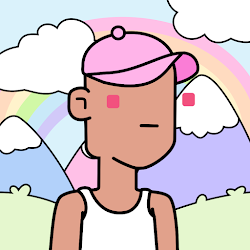

In [86]:
get_preview_image(elastic_df.iloc[477955])

In [87]:
elastic_df[elastic_df['cat_usd'] == 10] # biggest category

,creator,sale_usd,description,is_animation,name,collection_name,collection_description,contract_scheme,sale_token,id,...,instagram_tok,twitter_tok,word_count_coll_desc,word_count_descr,bin_log_usd,cat_usd,z_twitter_follower,contract_scheme_1,contract_scheme_2,contract_scheme_3
3,0x92bce497efe4332a8f611004f67e14093b5d0e8c,213.150420,"[collection, unique, croakz, vibe, bog, croak,...",False,CROAKZ 4323,croakz-v2-1,"[croakz, collection, small, amphibious, creatu...",1,ETH,j-sh530Bt_K6OZC-ZA99,...,40,102,48,16,10,10,-0.032753,1,0,0
17,FurBrawls,234.222920,"[dark, super, bunny, rare, conflict, superhero...",False,Dark Super Bunny #7106,darksuperbunnies,"[furbrawls, io, http, www, furbrawls, io, supe...",1,ETH,gulN5X0Bt_K6OZC-KYbq,...,0,464,148,16,10,10,-0.045880,1,0,0
18,AlienFrensDeployer,277.494612,"[alien, frens, collection, k, randomly, genera...",False,alien fren #6780,alienfrensnft,"[alien, frens, website, http, alienfrens, io, ...",1,ETH,felN5X0Bt_K6OZC-KIbd,...,0,31,97,25,10,10,-0.056105,1,0,0
19,Gray-Boys-Vault,277.494612,"[gray, boy, collection, generative, nfts, act,...",False,Gray Boy #7275,grayboys,"[gray, boy, collection, generative, nfts, act,...",1,ETH,F-lV5X0Bt_K6OZC-gI6l,...,36,26,77,77,10,10,-0.084071,1,0,0
22,fityeth,297.741000,"[collection, post, apocalypse, theme, chimp, n...",False,Apocalyptic Apes #2213,apocalyptic-apes,"[collection, post, apocalypse, theme, chimp, n...",1,ETH,GOlX5X0Bt_K6OZC-DI8I,...,69,65,32,31,10,10,-0.069626,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634556,Rug_Pull_FRENS,302.516100,"[rug, pull, frens, collection, cut, robbery, g...",False,RUG PULL FREN #694,rugpullfrens,"[rug, pull, fr, n, collection, cut, robbery, g...",1,ETH,LVr2Y34B3CmUIj-JxVC5,...,0,0,26,26,10,10,-0.053419,1,0,0
634569,TweakFactory,235.290300,"[twist, tweak, deconstruct, rebuild, original]",False,Twisted Tweak #2158,twistedtweaks,"[family, twisted, tweak, deconstruct, rebuild,...",1,ETH,qFr6Y34B3CmUIj-JUFcu,...,451,746,65,11,10,10,-0.087255,1,0,0
634578,,295.793520,"[bitcoin, billionaire, collection, unique, pix...",False,,bitcoinbillionaires,"[bitcoin, billionaire, collection, unique, pix...",1,ETH,IFoCZH4B3CmUIj-Jm2LY,...,0,238,78,78,10,10,-0.036748,1,0,0
634580,SadGirlsBar,285.709650,"[sad, cat, new, collection, sad, girl, bar, un...",False,The Sad Cat #6516,thesadcats,"[sad, girl, bar, http, opensea, io, collection...",1,ETH,NloCZH4B3CmUIj-JoWIu,...,41,0,52,29,10,10,-0.091952,1,0,0


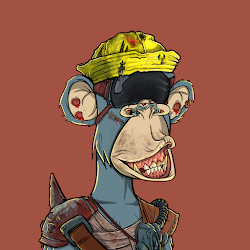

In [88]:
get_preview_image(elastic_df.loc[22])

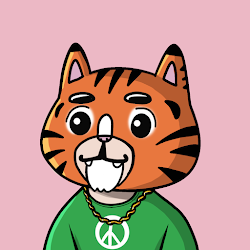

In [89]:
get_preview_image(elastic_df.loc[634587])

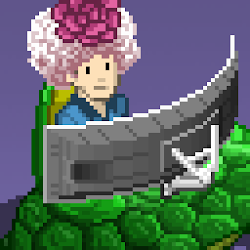

In [90]:
get_preview_image(elastic_df.loc[634578])

## Prep for models

In [19]:
Y = elastic_df['cat_usd'].copy()
X = elastic_df[['contract_scheme', 
                'sale_time', 'collection_created_year', 'unique_asset', 'instagram_account',
                'twitter_account', 'name_tok', 'creator_tok', 'collection_name_tok', 'instagram_tok', 
                'twitter_tok', 'id', 'preview_path', 'img_path',
                'word_count_coll_desc', 'word_count_descr', 'z_twitter_follower']]
# 'id', 'preview_path', 'img_path', 'contract_scheme_3', 'contract_scheme_1', 'contract_scheme_2', 'contract_scheme_3'

In [20]:
cat_col = ['contract_scheme', 'unique_asset', 'instagram_account',
                'twitter_account', 'name_tok', 'creator_tok', 'collection_name_tok', 'instagram_tok', 
                'twitter_tok']

In [21]:
cat_col

['contract_scheme',
 'unique_asset',
 'instagram_account',
 'twitter_account',
 'name_tok',
 'creator_tok',
 'collection_name_tok',
 'instagram_tok',
 'twitter_tok']

In [21]:
for category in cat_col:
    X[category] = X[category].astype('category')

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634592 entries, 0 to 634591
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   contract_scheme          634592 non-null  category
 1   sale_time                634592 non-null  int64   
 2   collection_created_year  634592 non-null  int64   
 3   unique_asset             634592 non-null  category
 4   instagram_account        634592 non-null  category
 5   twitter_account          634592 non-null  category
 6   name_tok                 634592 non-null  category
 7   creator_tok              634592 non-null  category
 8   collection_name_tok      634592 non-null  category
 9   instagram_tok            634592 non-null  category
 10  twitter_tok              634592 non-null  category
 11  word_count_coll_desc     634592 non-null  int64   
 12  word_count_descr         634592 non-null  int64   
 13  z_twitter_follower       634592 non-null  fl

In [22]:
num_col = ['sale_time', 'collection_created_year', 'word_count_coll_desc', 'word_count_descr', 'z_twitter_follower']

In [23]:
scaler = MinMaxScaler()

In [24]:
scaled = scaler.fit_transform(X[num_col])
for i, col in enumerate(X[num_col].columns):
    newCol = []
    for ii in range(0, len(scaled)):
        newCol.append(scaled[ii][i])
    X[col] = newCol
X

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,contract_scheme,sale_time,collection_created_year,unique_asset,instagram_account,twitter_account,name_tok,creator_tok,collection_name_tok,instagram_tok,twitter_tok,id,preview_path,img_path,word_count_coll_desc,word_count_descr,z_twitter_follower
0,1,0.478261,0.666667,0,1,1,0,1113,1392,443,714,e-sh530Bt_K6OZC-XA9q,C:\nft_data\preview\e-sh530Bt_K6OZC-XA9q_noext...,C:\nft_data\img\e-sh530Bt_K6OZC-XA9q_noext.png,0.625,0.000395,0.014450
1,1,0.478261,0.666667,0,0,1,0,22,80,0,0,eesh530Bt_K6OZC-XA9U,C:\nft_data\preview\eesh530Bt_K6OZC-XA9U_noext...,C:\nft_data\img\eesh530Bt_K6OZC-XA9U_noext.png,0.170,0.000099,0.054001
2,1,0.478261,0.666667,0,1,1,0,0,0,259,362,hush530Bt_K6OZC-Xw_b,C:\nft_data\preview\hush530Bt_K6OZC-Xw_b_noext...,C:\nft_data\img\hush530Bt_K6OZC-Xw_b_noext.png,0.075,0.000428,0.006391
3,1,0.478261,0.666667,0,1,1,30432,88,0,40,102,j-sh530Bt_K6OZC-ZA99,C:\nft_data\preview\j-sh530Bt_K6OZC-ZA99_noext...,C:\nft_data\img\j-sh530Bt_K6OZC-ZA99_noext.png,0.235,0.000124,0.019923
4,1,0.478261,0.666667,0,1,1,0,0,0,0,109,gOsh530Bt_K6OZC-Xw8i,C:\nft_data\preview\gOsh530Bt_K6OZC-Xw8i_noext...,C:\nft_data\img\gOsh530Bt_K6OZC-Xw8i_noext.png,0.270,0.000124,0.057486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634587,1,0.739130,0.666667,0,1,1,0,15654,14537,5866,7900,kloCZH4B3CmUIj-JvGLj,/scraper/data/preview/kloCZH4B3CmUIj-JvGLj_noe...,/scraper/data/img/kloCZH4B3CmUIj-JvGLj_noext.png,0.190,0.000313,0.013278
634588,1,0.739130,1.000000,0,0,0,0,321,0,0,0,aVoCZH4B3CmUIj-JsWKI,/scraper/data/preview/aVoCZH4B3CmUIj-JsWKI_noe...,/scraper/data/img/aVoCZH4B3CmUIj-JsWKI_noext.png,0.440,0.000239,0.000000
634589,2,0.739130,0.666667,0,0,0,12075,0,0,0,0,Z1oCZH4B3CmUIj-JsWJy,/scraper/data/preview/Z1oCZH4B3CmUIj-JsWJy_noe...,/scraper/data/img/Z1oCZH4B3CmUIj-JsWJy_noext.png,0.085,0.000140,0.000000
634590,1,0.739130,0.666667,0,0,0,0,61,90,0,0,ZFoCZH4B3CmUIj-JsWJO,/scraper/data/preview/ZFoCZH4B3CmUIj-JsWJO_noe...,/scraper/data/img/ZFoCZH4B3CmUIj-JsWJO_noext.png,0.060,0.000099,0.000000


Do Not DO

In [29]:
scaler = MinMaxScaler()

In [24]:
scaled = scaler.fit_transform(X)
for i, col in enumerate(X.columns):
    newCol = []
    for ii in range(0, len(scaled)):
        newCol.append(scaled[ii][i])
    X[col] = newCol
X

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,contract_scheme_1,contract_scheme_2,sale_time,collection_created_year,unique_asset,instagram_account,twitter_account,name_tok,creator_tok,collection_name_tok,instagram_tok,twitter_tok,word_count_coll_desc,word_count_descr,z_twitter_follower
0,1.0,0.0,0.478261,0.666667,0.0,1.0,1.0,0.000000,0.071100,0.095756,0.075520,0.090380,0.625,0.000395,0.014450
1,1.0,0.0,0.478261,0.666667,0.0,0.0,1.0,0.000000,0.001405,0.005503,0.000000,0.000000,0.170,0.000099,0.054001
2,1.0,0.0,0.478261,0.666667,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.044153,0.045823,0.075,0.000428,0.006391
3,1.0,0.0,0.478261,0.666667,0.0,1.0,1.0,0.235072,0.005622,0.000000,0.006819,0.012911,0.235,0.000124,0.019923
4,1.0,0.0,0.478261,0.666667,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.013797,0.270,0.000124,0.057486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634587,1.0,0.0,0.739130,0.666667,0.0,1.0,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.190,0.000313,0.013278
634588,1.0,0.0,0.739130,1.000000,0.0,0.0,0.0,0.000000,0.020506,0.000000,0.000000,0.000000,0.440,0.000239,0.000000
634589,0.0,1.0,0.739130,0.666667,0.0,0.0,0.0,0.093273,0.000000,0.000000,0.000000,0.000000,0.085,0.000140,0.000000
634590,1.0,0.0,0.739130,0.666667,0.0,0.0,0.0,0.000000,0.003897,0.006191,0.000000,0.000000,0.060,0.000099,0.000000


In [28]:
X['id'] = elastic_df['id']
X['preview_path'] = elastic_df['preview_path']
X['img_path'] = elastic_df['img_path']

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634592 entries, 0 to 634591
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   contract_scheme          634592 non-null  category
 1   sale_time                634592 non-null  float64 
 2   collection_created_year  634592 non-null  float64 
 3   unique_asset             634592 non-null  category
 4   instagram_account        634592 non-null  category
 5   twitter_account          634592 non-null  category
 6   name_tok                 634592 non-null  category
 7   creator_tok              634592 non-null  category
 8   collection_name_tok      634592 non-null  category
 9   instagram_tok            634592 non-null  category
 10  twitter_tok              634592 non-null  category
 11  id                       634592 non-null  object  
 12  preview_path             634592 non-null  object  
 13  img_path                 634592 non-null  ob

In [26]:
train_size = 0.5

In [27]:
X_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size = train_size, random_state=69)

# Now since we want the valid and test size to be equal (20% each of overall data). 
# we have to define valid_size = 0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, random_state=42)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(317296, 17)
(317296,)
(158648, 17)
(158648,)
(158648, 17)
(158648,)


(None, None)

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317296 entries, 93549 to 457782
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   contract_scheme          317296 non-null  category
 1   sale_time                317296 non-null  float64 
 2   collection_created_year  317296 non-null  float64 
 3   unique_asset             317296 non-null  category
 4   instagram_account        317296 non-null  category
 5   twitter_account          317296 non-null  category
 6   name_tok                 317296 non-null  category
 7   creator_tok              317296 non-null  category
 8   collection_name_tok      317296 non-null  category
 9   instagram_tok            317296 non-null  category
 10  twitter_tok              317296 non-null  category
 11  id                       317296 non-null  object  
 12  preview_path             317296 non-null  object  
 13  img_path                 317296 non-null

In [31]:
del elastic_df

## Split the data for LogReg

In [30]:
train_size = 0.7

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, train_size = train_size, random_state=69)

In [63]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(446127, 16)
(446127,)
(191198, 16)
(191198,)


(None, None)

In [82]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446127 entries, 84135 to 464472
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   contract_scheme_1        446127 non-null  float64
 1   contract_scheme_2        446127 non-null  float64
 2   contract_scheme_3        446127 non-null  float64
 3   sale_time                446127 non-null  float64
 4   collection_created_year  446127 non-null  float64
 5   unique_asset             446127 non-null  float64
 6   instagram_account        446127 non-null  float64
 7   twitter_account          446127 non-null  float64
 8   name_tok                 446127 non-null  float64
 9   creator_tok              446127 non-null  float64
 10  collection_name_tok      446127 non-null  float64
 11  instagram_tok            446127 non-null  float64
 12  twitter_tok              446127 non-null  float64
 13  word_count_coll_desc     446127 non-null  float64
 14  

## Multinomial Logistic Regression

In [54]:
from sklearn import linear_model
from sklearn import metrics
import statsmodels.api as sm

In [77]:
 mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty='l2').fit(X_train, y_train)

In [78]:
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))

Multinomial Logistic regression Train Accuracy ::  0.28429124442143155
Multinomial Logistic regression Test Accuracy ::  0.28422368434816264


In [80]:
from sklearn.metrics import classification_report

In [81]:
#Create classification report
class_report=classification_report(y_test, mul_lr.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       521
           1       0.00      0.00      0.00        71
           2       0.00      0.00      0.00       710
           3       0.00      0.00      0.00       885
           4       0.04      0.00      0.01      3089
           5       0.15      0.01      0.02     10307
           6       0.34      0.14      0.20     23031
           7       0.27      0.27      0.27     40612
           8       0.29      0.74      0.42     48674
           9       0.21      0.07      0.10     31240
          10       0.17      0.01      0.01     16345
          11       0.14      0.01      0.02      7904
          12       0.47      0.27      0.34      4344
          13       0.49      0.10      0.17      2356
          14       0.00      0.00      0.00       805
          15       0.00      0.00      0.00       112
          16       0.84      0.73      0.78       182
          17       0.00    

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0. Feature: contract_scheme_1 | Score: 0.67038
1. Feature: contract_scheme_2 | Score: 0.54521
2. Feature: contract_scheme_3 | Score: 0.99218
3. Feature: sale_time | Score: 0.41682
4. Feature: collection_created_year | Score: 0.89902
5. Feature: unique_asset | Score: 0.59149
6. Feature: instagram_account | Score: 0.84654
7. Feature: twitter_account | Score: 0.53707
8. Feature: name_tok | Score: 0.39761
9. Feature: creator_tok | Score: 1.35621
10. Feature: collection_name_tok | Score: 1.74968
11. Feature: instagram_tok | Score: 1.08515
12. Feature: twitter_tok | Score: 1.67784
13. Feature: word_count_coll_desc | Score: 0.81787
14. Feature: word_count_descr | Score: 0.30229
15. Feature: z_twitter_follower | Score: 9.77530


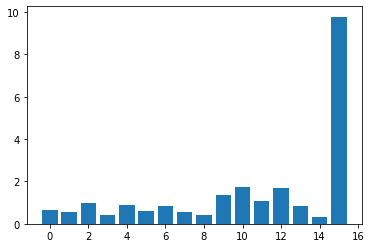

In [126]:
# get importance
importance_all = np.abs(mul_lr.coef_)
importance = []
for i in range( len(importance_all[0]) ):
    importance_list = []
    for ii in range( len(bin_labels) ):
        importance_list.append(importance_all[ii][i])
    feat_importance = np.mean(importance_list)
    importance.append(feat_importance)
    
    print('%0.0f. Feature: %s | Score: %.5f' % (i, X_train.columns[i], feat_importance))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [24]:
#logit_model=sm.MNLogit(y_train, sm.add_constant(X_train[['z_twitter_follower', 'sale_time']]))

#result=logit_model.fit()
#stats1=result.summary()
#stats2=result.summary2()
#print(stats1)
#print(stats2)

#https://www.datasklr.com/logistic-regression/multinomial-logistic-regression

## XGBoost

In [22]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [26]:
classiefier = XGBClassifier(eval_metric = 'mlogloss', use_label_encoder=False)

In [29]:
param_grid = {
    'objective': 'multi:softmax',
    'num_class': [19],
    'max_depth': [5, 7, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 0.9],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9],
    'min_child_weight': [1.0, 3.0, 5.0],
    'gamma': [1.0, 1.5, 2.0],
    'reg_lambda': [0.1, 0.2, 0.3],
    'n_estimators': [25, 50, 100]
        }

In [30]:
t = time()
search = RandomizedSearchCV(classiefier, param_grid, n_iter=30, cv=5, random_state=42).fit(X_train, y_train)
print("The best hyperparameters are ", search.best_params_)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


The best hyperparameters are  {'subsample': 0.8, 'reg_lambda': 0.1, 'objective': 'f', 'num_class': 19, 'n_estimators': 100, 'min_child_weight': 1.0, 'max_depth': 15, 'learning_rate': 0.2, 'gamma': 1.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8}
Time to train the model: 121.51 mins


In [31]:
classiefier = XGBClassifier(colsample_bytree = search.best_params_['colsample_bytree'],
                             n_estimators  = search.best_params_['n_estimators'],
                             max_depth = search.best_params_['max_depth'],
                             learning_rate = search.best_params_["learning_rate"],
                             subsample = search.best_params_['subsample'],
                             colsample_bylevel = search.best_params_['colsample_bylevel'],
                             min_child_weight = search.best_params_['min_child_weight'],
                             gamma = search.best_params_['gamma'],
                             reg_lambda = search.best_params_['reg_lambda'],
                             eval_metric = 'mlogloss', nrounds = 50,
                               )

classiefier.fit(X_train, y_train)

# early_stopping_rounds = search.best_params_['early_stopping_rounds'],

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:06:18] WARNING: ..\src\learner.cc:576: 
Parameters: { "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='mlogloss', gamma=1.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, nrounds=50, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, ...)

In [32]:
predictions_val = classiefier.predict(X_valid)

In [36]:
predictions_test = classiefier.predict(X_test)

In [33]:
print("Classification Report")
print(classification_report(y_valid, predictions_val))

Classification Report
              precision    recall  f1-score   support

           0       0.46      0.26      0.33       490
           1       0.48      0.13      0.21        75
           2       0.46      0.28      0.35       569
           3       0.41      0.35      0.38       699
           4       0.52      0.46      0.49      2651
           5       0.56      0.60      0.58      8563
           6       0.64      0.70      0.67     19264
           7       0.67      0.75      0.71     33982
           8       0.73      0.75      0.74     40495
           9       0.76      0.68      0.72     25905
          10       0.78      0.67      0.72     13545
          11       0.76      0.66      0.71      6533
          12       0.78      0.69      0.73      3669
          13       0.78      0.69      0.73      1991
          14       0.71      0.65      0.67       633
          15       0.45      0.14      0.22        99
          16       0.87      0.85      0.86       161
     

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
print("Classification Report")
print(classification_report(y_test, predictions_test))

Classification Report
              precision    recall  f1-score   support

           0       0.46      0.27      0.34       443
           1       0.52      0.17      0.26        76
           2       0.47      0.28      0.35       603
           3       0.45      0.38      0.41       762
           4       0.50      0.47      0.48      2517
           5       0.57      0.60      0.59      8549
           6       0.63      0.69      0.66     19314
           7       0.67      0.74      0.71     33713
           8       0.74      0.75      0.74     40762
           9       0.76      0.69      0.72     26025
          10       0.77      0.67      0.71     13543
          11       0.77      0.65      0.71      6595
          12       0.78      0.70      0.74      3600
          13       0.77      0.70      0.73      1896
          14       0.76      0.67      0.71       687
          15       0.52      0.12      0.20        91
          16       0.85      0.85      0.85       146
     

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from sklearn.metrics import accuracy_score

In [35]:
accuracy_val = accuracy_score(y_valid, predictions_val)
accuracy_val

0.7003721811825696

In [38]:
accuracy_test = accuracy_score(y_test, predictions_test)
accuracy_test

0.7005121381768885

## Feature importance

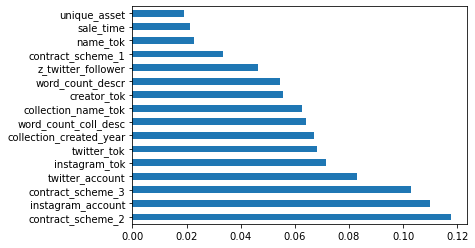

In [41]:
feature_importances_xgb = pandas.Series(classiefier.feature_importances_, index = X.columns)
feature_importances_xgb.nlargest(17).plot(kind = 'barh');

## Pickle 

Save

In [32]:
pickle_save_path_X_train = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\X_train.pkl'
with open(pickle_save_path_X_train,'wb') as path_name:
    pickle.dump(X_train, path_name) 
    
pickle_save_path_y_train = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\y_train.pkl'
with open(pickle_save_path_y_train,'wb') as path_name:
    pickle.dump(y_train, path_name)
    
pickle_save_path_X_valid = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\X_valid.pkl'
with open(pickle_save_path_X_valid,'wb') as path_name:
    pickle.dump(X_valid, path_name)
    
pickle_save_path_y_valid = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\y_valid.pkl'
with open(pickle_save_path_y_valid,'wb') as path_name:
    pickle.dump(y_valid, path_name)
    
pickle_save_path_X_test = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\X_test.pkl'
with open(pickle_save_path_X_test,'wb') as path_name:
    pickle.dump(X_test, path_name)
    
pickle_save_path_y_test = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\y_test.pkl'
with open(pickle_save_path_y_test,'wb') as path_name:
    pickle.dump(y_test, path_name) 

Open

In [33]:
pickle_save_path_X_train = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\X_train.pkl'
with open(pickle_save_path_X_train,'rb') as path_name:
    X_train = pickle.load(path_name)
    
pickle_save_path_y_train = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\y_train.pkl'
with open(pickle_save_path_y_train,'rb') as path_name:
    y_train = pickle.load(path_name)
    
pickle_save_path_X_valid = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\X_valid.pkl'
with open(pickle_save_path_X_valid,'rb') as path_name:
    X_valid = pickle.load(path_name)
    
pickle_save_path_y_valid = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\y_valid.pkl'
with open(pickle_save_path_y_valid,'rb') as path_name:
    y_valid = pickle.load(path_name)
    
pickle_save_path_X_test = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\X_test.pkl'
with open(pickle_save_path_X_test,'rb') as path_name:
    X_test = pickle.load(path_name)

pickle_save_path_y_test = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\y_test.pkl'
with open(pickle_save_path_y_test,'rb') as path_name:
    y_test = pickle.load(path_name)

In [28]:
type(X_train)

pandas.core.frame.DataFrame

## Deep Learning for tabular data
https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

https://stackabuse.com/introduction-to-pytorch-for-classification/

In [22]:
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634592 entries, 0 to 634591
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   contract_scheme_1        634592 non-null  float64
 1   contract_scheme_2        634592 non-null  float64
 2   sale_time                634592 non-null  float64
 3   collection_created_year  634592 non-null  float64
 4   unique_asset             634592 non-null  float64
 5   instagram_account        634592 non-null  float64
 6   twitter_account          634592 non-null  float64
 7   name_tok                 634592 non-null  float64
 8   creator_tok              634592 non-null  float64
 9   collection_name_tok      634592 non-null  float64
 10  instagram_tok            634592 non-null  float64
 11  twitter_tok              634592 non-null  float64
 12  word_count_coll_desc     634592 non-null  float64
 13  word_count_descr         634592 non-null  float64
 14  z_tw

In [23]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [24]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test, y_test = np.array(X_test), np.array(y_test)

In [25]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [26]:
EPOCHS = 50
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 20

In [27]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [28]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
model = MulticlassClassification(num_feature=NUM_FEATURES, num_class=NUM_CLASSES)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=16, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=20, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [31]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [32]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [33]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
print(f"""Epoch {e+0:03}:| Train Loss:
      {train_epoch_loss/len(train_loader):.5f} | Val Loss:
      {val_epoch_loss/len(val_loader):.5f} | Train Acc:
      {train_epoch_acc/len(train_loader):.3f}| Val Acc:
      {val_epoch_acc/len(val_loader):.3f}""")

Begin training.


100%|████████████████████████████████████████████████████| 50/50 [2:07:35<00:00, 153.11s/it]

Epoch 050:| Train Loss:
      1.24379 | Val Loss:
      1.19054 | Train Acc:
      52.599| Val Acc:
      54.994


In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [40]:
#loss_stats

In [41]:
#accuracy_stats

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

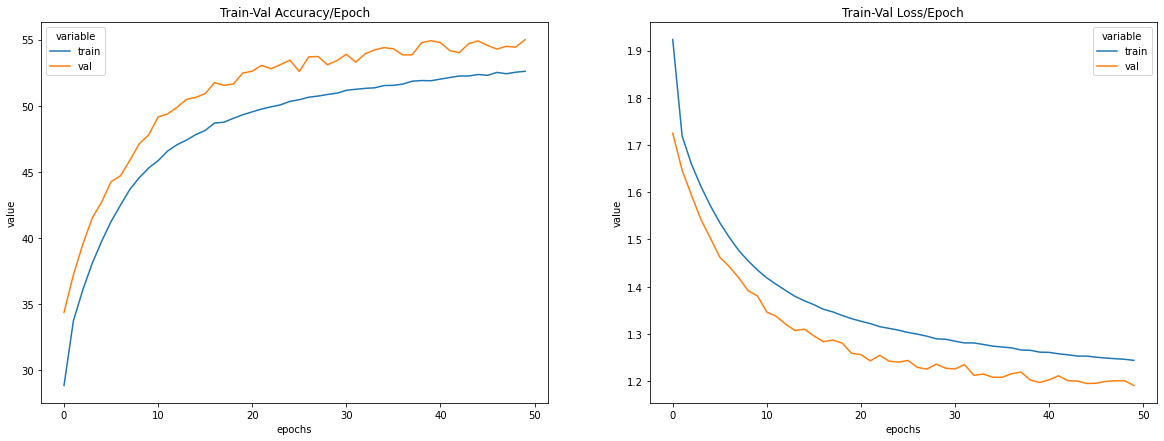

In [37]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=
                                                          ['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=
                                                      ['index']).rename(columns=
                                                                        {"index":"epochs"})# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [42]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

<AxesSubplot:>

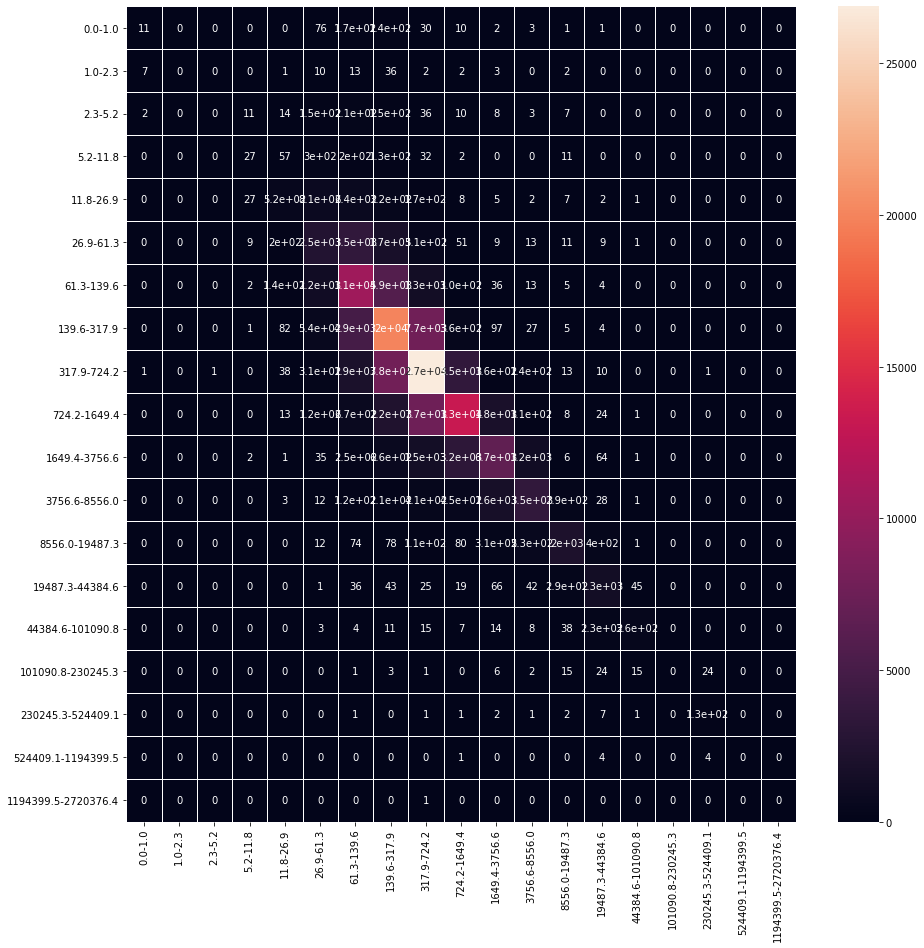

In [50]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx_to_class, index=idx_to_class)

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(confusion_matrix_df, annot=True, linewidths=.5, ax=ax)

In [46]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.52      0.02      0.05       443
           1       0.00      0.00      0.00        76
           2       0.00      0.00      0.00       603
           3       0.34      0.04      0.06       762
           4       0.49      0.21      0.29      2517
           5       0.41      0.29      0.34      8549
           6       0.45      0.55      0.50     19314
           7       0.51      0.59      0.55     33713
           8       0.58      0.66      0.62     40762
           9       0.63      0.51      0.57     26025
          10       0.62      0.49      0.55     13543
          11       0.63      0.53      0.57      6595
          12       0.74      0.56      0.63      3600
          13       0.62      0.70      0.66      1896
          14       0.84      0.52      0.65       687
          15       0.00      0.00      0.00        91
          16       0.82      0.89      0.85       146
          17       0.00    

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
torch.save(model.state_dict(), 'C:\\NFT_data\\networks\\nn_tab.pt')

In [105]:
model.eval()
for X_val_batch, y_val_batch in val_loader:
    print('predicted', model(X_val_batch.to(device)))
    print('expected: ', y_val_batch)
    break

predicted tensor([[ -4.6980,  -8.3305,  -3.6818,  -6.9765,  -5.3307,  -4.1757,  -2.5448,
           2.1147,   3.7509,   2.8908,   0.6465,  -1.6794,  -3.0961,  -5.3248,
          -7.6417,  -9.8888, -10.4467, -14.9088, -18.3218, -17.0523]],
       device='cuda:0', grad_fn=<AddmmBackward>)
expected:  tensor([9])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [119]:
rand_index = np.random.random_sample((50,) ) * len(X_train)
X_sample = []
for i in rand_index:
    X_sample.append(X_train[int(i)])
X_sample

[array([0.        , 1.        , 0.        , 0.2173913 , 0.66666667,
        0.        , 0.        , 0.        , 0.        , 0.09225069,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.04347826e-01,
        6.66666667e-01, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 6.13300965e-03, 1.02574694e-02, 0.00000000e+00,
        5.19053045e-03, 2.97979798e-01, 1.64782652e-04, 2.17228422e-02]),
 array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.08695652e-01,
        6.66666667e-01, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.01707283e-02, 0.00000000e+00,
        1.40524117e-02, 3.63636364e-01, 5.93217546e-04, 4.11104930e-02]),
 array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.47826087e-01,
        6.66666667e-01, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000

In [91]:
#import shap
#from torch.autograd import Variable
import lime
import lime.lime_tabular

In [92]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names = idx_to_class)

In [1]:
#exp = explainer.explain_instance(torch.from_numpy(X_sample[0]).to(device), model, num_features=20)
#exp.show_in_notebook(show_all=False)

## Resnet50

In [79]:
import torch
from collections import Counter
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
#from torchsummary import summary
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import tqdm
from timeit import default_timer as timer
from torch import Tensor, nn
from torch.nn.functional import interpolate

save_file_name = 'C:\\NFT_data\\networks\\resnet50-transfer.pt'
checkpoint_path = 'C:\\NFT_data\\networks\\resnet50-transfer.pth'

# Change to fit hardware
batch_size = 1024

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


In [80]:
model = models.resnet50(pretrained = True)

In [81]:
#Freeze our model's weights because we use pretrained one
for param in model.parameters():
    param.requires_grad = False

In [82]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [84]:
n_classes = len(bin_labels)
print(f'There are {n_classes} different classes.')

There are 20 different classes.


In [85]:
n_inputs = model.fc.in_features

model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 250), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(250, n_classes),                   
                      nn.LogSoftmax(dim=1))

model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=250, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=250, out_features=20, bias=True)
  (4): LogSoftmax(dim=1)
)

In [86]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

24,025,302 total parameters.
517,270 training parameters.


In [87]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

In [88]:
if multi_gpu:
    print(model.module.fc)
else:
    print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=250, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=250, out_features=20, bias=True)
  (4): LogSoftmax(dim=1)
)


In [89]:
model.class_to_idx = class_to_idx
model.idx_to_class = idx_to_class

list(model.idx_to_class.items())[:10]

[(0, '0.0-1.0'),
 (1, '1.0-2.3'),
 (2, '2.3-5.2'),
 (3, '5.2-11.8'),
 (4, '11.8-26.9'),
 (5, '26.9-61.3'),
 (6, '61.3-139.6'),
 (7, '139.6-317.9'),
 (8, '317.9-724.2'),
 (9, '724.2-1649.4')]

In [90]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [91]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([250, 2048])
torch.Size([250])
torch.Size([20, 250])
torch.Size([20])


In [92]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(250),
             T.CenterCrop(224),
             T.ToTensor(), 
             T.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])])

In [95]:
from pickledataset import PickleSeriesDataset

In [96]:
# Dataloader iterators
dataloaders = {
    'train': DataLoader(
        PickleSeriesDataset(pickle_save_path_X_train, pickle_save_path_y_train, trf), 
        batch_size=batch_size,
        shuffle=False,
        num_workers=10,
        
    ),
    'val': DataLoader(
        PickleSeriesDataset(pickle_save_path_X_valid, pickle_save_path_y_valid, trf), 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=10,
        
    ),
    'test': DataLoader(
        PickleSeriesDataset(pickle_save_path_X_test, pickle_save_path_y_test, trf), 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=10,
        
    )
}

In [97]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            #print(data)
            #print(target)

            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for ii, (data, target) in enumerate(valid_loader):
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                    
                    # Track validation progress
                    print(
                        f'Epoch: {epoch}\t{100 * (ii + 1) / len(valid_loader):.2f}% validated. {timer() - start:.2f} seconds elapsed in epoch.',
                        end='\r')

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [98]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=50,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	102.56% validated. 2579.11 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.9311 	Validation Loss: 1.8577
		Training Accuracy: 29.47%	 Validation Accuracy: 31.15%
Epoch: 1	102.56% validated. 2500.17 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.8127 	Validation Loss: 1.7792
		Training Accuracy: 33.39%	 Validation Accuracy: 33.52%
Epoch: 2	102.56% validated. 702.22 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.7668 	Validation Loss: 1.7226
		Training Accuracy: 34.67%	 Validation Accuracy: 36.65%
Epoch: 3	102.56% validated. 515.42 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.7358 	Validation Loss: 1.7055
		Training Accuracy: 35.63%	 Validation Accuracy: 37.84%
Epoch: 4	102.56% validated. 515.11 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.7067 	Validation Loss: 1.6969
		Training Accuracy: 36.60%	 Validation Accuracy: 36.59%
Epoch: 5	102.56% validated. 515.12 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.69

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5, 1.0, 'Training and Validation Losses')

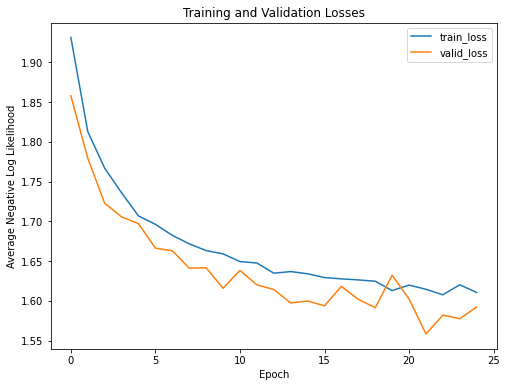

In [99]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

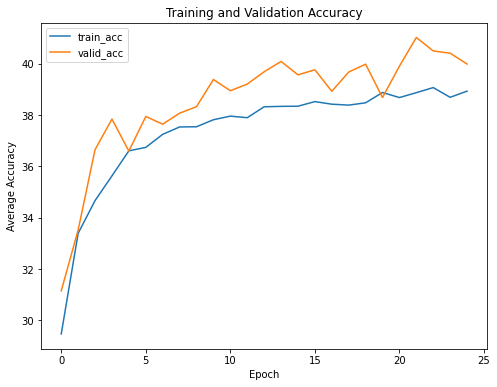

In [100]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [101]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    if '\\' in model_name:
        model_name = model_name.split('\\')[-1]
    print(model_name)
    assert (model_name in ['resnet50']), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [102]:
save_checkpoint(model, path=checkpoint_path)

resnet50


In [ ]:
idx_to_class = {
    idx: class_
    for idx, class_ in enumerate(bin_labels)
}
class_to_idx = {bin_labels[i]: i for i in range(len(bin_labels))}

class_to_idx

In [103]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    if '\\' in model_name:
        model_name = model_name.split('\\')[-1]
    print(model_name)
    assert (model_name in ['resnet50']), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [104]:
model, optimizer = load_checkpoint(path=checkpoint_path)

resnet50
24,025,302 total parameters.
517,270 total gradient parameters.


In [105]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [106]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    res = accuracy(model(features.to('cuda')), targets, topk=(1, ))
else:
    res = accuracy(model(features), targets, topk=(1, 5))
print(res)

[41.89453125]


In [107]:
def evaluate(model, test_loader, criterion, topk=(1, 3, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """
    confusion_matrix = torch.zeros(n_classes, n_classes)
    classes = []
    losses = []
    estimated_len = len(test_loader.dataset)
    # Hold accuracy results
    acc_results = np.zeros((estimated_len, len(topk)))
    i = 0
    start = timer()
    
    print(f'Starting Evaluatation.\n')

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in (test_loader):

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            _, predscm = torch.max(out, 1)
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1
            
                # Track progress
                print(
                    f'i: {i} / {estimated_len} evaluated. {timer() - start:.2f} seconds elapsed.',
                    end='\r')

    # Send results to a dataframe and calculate average across classes
    diff_len =  estimated_len - i
    acc_results = acc_results[:-diff_len]
    print(f'\n{len(acc_results)}')
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'}),confusion_matrix

criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results,confusion_matrix = evaluate(model, dataloaders['test'], criterion)

Starting Evaluatation.

i: 159326 / 159332 evaluated. 339.73 seconds elapsed.
159326


In [108]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'outputs/confusion_matrix.png')
    return plt

In [109]:
classnames = [model.idx_to_class[i] for i in range(0,n_classes)]

Confusion matrix, without normalization


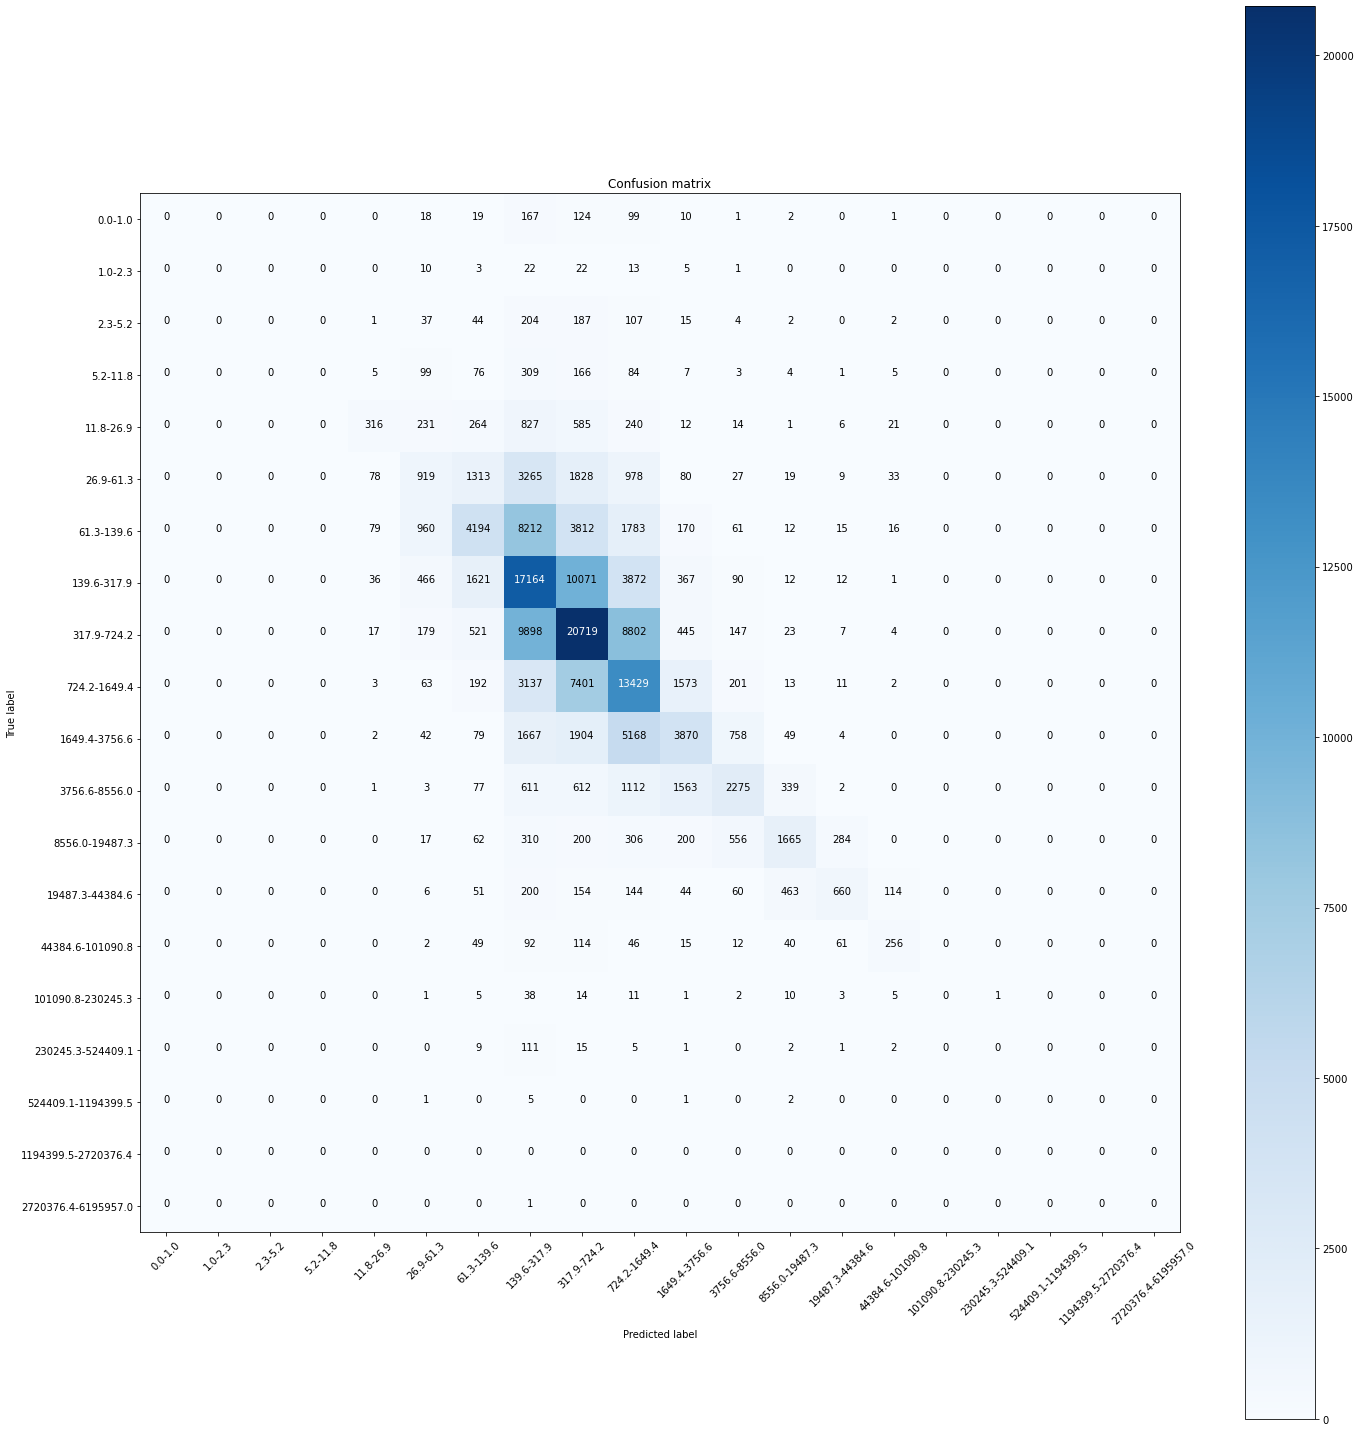

In [110]:
plt.figure(figsize=(20,20))
plt = plot_confusion_matrix(confusion_matrix, classnames)

In [111]:
def cm_as_dataframe(cm):
    cm = pd.DataFrame(cm)
    cm.columns = classnames
    cm.index = classnames
    cm = cm.reset_index()
    return cm

cm_as_dataframe(confusion_matrix.cpu().numpy()).to_csv(f'outputs/confmat.csv',index=None)

In [112]:
print(f"Overall Accuracy:{confusion_matrix.diag().sum()/confusion_matrix.sum()}")

Overall Accuracy:0.41089966893196106


In [ ]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

## Two models

In [26]:
import torchvision
import torch.nn as nn
from torch import Tensor

https://discuss.pytorch.org/t/concatenate-layer-output-with-additional-input-data/20462/2
https://discuss.pytorch.org/t/how-to-combine-tabular-and-image-data/79465/2

In [28]:
class MulticlassClassification(nn.Module):
    def __init__(self, cat_size, num_col, output_size, layers, p=0.4):
        super(MulticlassClassification, self).__init__()
        
        # IMAGE: ResNet
        self.cnn = models.resnet50(pretrained = True)
        for param in self.cnn.parameters():
            param.requires_grad = False
        n_inputs = self.cnn.fc.in_features
        self.cnn.fc = nn.Sequential(
          nn.Linear(n_inputs, 250), 
          nn.ReLU(), 
          nn.Dropout(p),
          nn.Linear(250, output_size),                   
          nn.LogSoftmax(dim=1)
        )
        
        # TABLE: 
        self.all_embeddings = nn.ModuleList(
            [nn.Embedding(categories, size) for categories, size in cat_size]
        )
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_col)

        all_layers = []
        num_cat_col = sum(e.embedding_dim for e in self.all_embeddings)
        input_size = num_cat_col + num_col

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)
        
        #combine
        self.combine_fc =  = nn.Linear(output_size * 2, output_size)

    def forward(self, x_categorical, x_numerical, image):
        embeddings = []
        for i, embedding in enumerate(self.all_embeddings):
            embeddings.append(embedding(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        
        # img
        x2 = self.cnn(image)
        
        # combine
        x3 = torch.cat([x, x2], 1)
        x3 = F.relu(self.combine_fc(x3))
        
        return x

In [29]:
model = MultiInputResNet(num_feature = NUM_FEATURES, num_class = NUM_CLASSES, pretrained_resnet=True)
model

model = MulticlassClassification(categorical_embedding_sizes, train_num.shape[1], 20, [403, 376], p=0.2).to(device)

MultiInputResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

In [30]:
#Freeze our model's weights because we use pretrained one
for param in model.parameters():
    param.requires_grad = False

In [31]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

27,672,470 total parameters.
0 training parameters.


In [32]:
from torch import cuda, optim

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


In [33]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

In [34]:
if multi_gpu:
    print(model.module.fc)
else:
    print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [35]:
model.class_to_idx = class_to_idx
model.idx_to_class = idx_to_class

list(model.idx_to_class.items())[10:]

[(10, '1649.4-3756.6'),
 (11, '3756.6-8556.0'),
 (12, '8556.0-19487.3'),
 (13, '19487.3-44384.6'),
 (14, '44384.6-101090.8'),
 (15, '101090.8-230245.3'),
 (16, '230245.3-524409.1'),
 (17, '524409.1-1194399.5'),
 (18, '1194399.5-2720376.4'),
 (19, '2720376.4-6195957.0')]

In [36]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [38]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

In [39]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(250),
             T.CenterCrop(224),
             T.ToTensor(), 
             T.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])])
#trf_tab = T.ToTensor() # transforms.Compose([transforms.ToTensor()])
#trf_tab = T.Compose([transforms.ToTensor()])

In [40]:
from picklemultidataset import PickleMultiDataset

from pickle import load
import pandas
from torch.utils.data import IterableDataset, get_worker_info
from torch import as_tensor
from PIL import Image
import math
import os

class PickleMultiDataset(IterableDataset):
    """A dataset that reads a pickle file and returns its content
    """

    def __init__(self, x_path, y_path, img_transform=None, tab_transform=None, target_transform=None):
        super(PickleMultiDataset).__init__()
        self.img_transform = img_transform
        self.target_transform = target_transform
        self.tab_transform = tab_transform
        
        with open(x_path,'rb') as path_name:
            self.x = load(path_name)
        with open(y_path,'rb') as path_name:
            self.y = load(path_name)
            
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        
        data = self.x.iloc[index]
        img = self.get_preview_image(data)
        target = self.y.iloc[index]
        
        if self.img_transform is not None and img is not None:
            img = self.img_transform(img)
        if self.tab_transform is not None:
            target = self.tab_transform(data)
        if self.target_transform is not None:
            target = self.target_transform(target)

        data_without_path = data[['contract_scheme_1', 'contract_scheme_2', 'contract_scheme_3', 
                'sale_time', 'collection_created_year', 'unique_asset', 'instagram_account',
                'twitter_account', 'name_tok', 'creator_tok', 'collection_name_tok', 'instagram_tok', 
                'twitter_tok', 'word_count_coll_desc', 'word_count_descr', 'z_twitter_follower']]
        return img, data_without_path, target

    def __len__(self):
        return len(self.x)
    
    def __iter__(self):
        end = len(self.x)
        worker_info = get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = 0
            iter_end = end
        else: # in a worker process split workload
            per_worker = int(math.ceil(end / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = worker_id * per_worker
            iter_end = min(iter_start + per_worker, end)
        for i in range(iter_start, iter_end):
            img, data, target = self.__getitem__(i)
            if img is not None:
                yield img, data, target

    def get_preview_image(self, row):
        img_path = []
        preview = row['preview_path']
        if preview and preview.startswith('/scraper/data/preview/'):
            preview = os.path.join(os.sep, 'C:' + os.sep, 'nft_data', 'preview', preview[len('/scraper/data/preview/'):])
        if preview != None and pandas.isna(preview) == False:
            img_path.append(preview)
        
        id = row['id']
        image_folder = '..\\..\\opensea_scapper\\opensea_nft_scrapper\\data\\'
        img_path.append(image_folder + 'preview\\' + id + '_noext.png')
        #img_path.append(image_folder + 'img\\' + id + '_noext.png')
        #orginal = row['img_path']
        #if orginal != None and pandas.isna(orginal) == False:
        #    img_path.append(orginal)
        #    if orginal.count('\\') > 0:
        #        img_path.append(image_folder + 'img\\' + orginal[orginal.rindex('\\') + 1:])

        img = None
        for path in img_path:
            try:
                img = Image.open(path).convert('RGB')
                break
            except:
                print(f'IMG NOT FOUND in: {path}')

        return img
    

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


In [41]:
# Dataloader iterators
dataloaders = {
    'train': DataLoader(
        PickleMultiDataset(pickle_save_path_X_train, pickle_save_path_y_train, trf), 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=5,
        
    ),
    'val': DataLoader(
        PickleMultiDataset(pickle_save_path_X_valid, pickle_save_path_y_valid, trf), 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=5,
        
    ),
    'test': DataLoader(
        PickleMultiDataset(pickle_save_path_X_test, pickle_save_path_y_test, trf  ), 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=5,
        
    )
}

In [42]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (img, data, target) in enumerate(train_loader):
            #print(data)
            #print(img)

            # Tensors to gpu
            if train_on_gpu:
                img, data, target = img.cuda(), data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(img, data)
            
            #output = torch.cat((output_img, output_tab), dim=1)
            #output = self.relu(output)
            #m = nn.Softmax(dim=1)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * img.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for ii, (img, data, target) in enumerate(valid_loader):
                    # Tensors to gpu
                    if train_on_gpu:
                        img, data, target = img.cuda(), data.cuda(), target.cuda()

                    # Forward pass
                    output = model(img, data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * img.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * img.size(0)
                    
                    # Track validation progress
                    print(
                        f'Epoch: {epoch}\t{100 * (ii + 1) / len(valid_loader):.2f}% validated. {timer() - start:.2f} seconds elapsed in epoch.',
                        end='\r')

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [43]:
import torch
from collections import Counter
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
#from torchsummary import summary
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import tqdm
from timeit import default_timer as timer
from torch import Tensor, nn
from torch.nn.functional import interpolate

In [44]:
save_file_name = 'C:\\NFT_data\\networks\\res_tab-transfer.pt'
checkpoint_path = 'C:\\NFT_data\\networks\\res_tab-transfer.pth'

In [2]:
#model, history = train(
#    model,
#    criterion,
#    optimizer,
#    dataloaders['train'],
#    dataloaders['val'],
#    save_file_name=save_file_name,
#    max_epochs_stop=3,
#    n_epochs=3,
#    print_every=1)
#RuntimeError: mat1 dim 1 must match mat2 dim 0

In [58]:
import torch

In [44]:
torch.as_tensor([0.1,0.22,0.9,1])

tensor([0.1000, 0.2200, 0.9000, 1.0000])

In [45]:
torch.as_tensor(X[['contract_scheme_1', 'contract_scheme_2', 'contract_scheme_3', 
                'sale_time', 'collection_created_year', 'unique_asset', 'instagram_account',
                'twitter_account', 'name_tok', 'creator_tok', 'collection_name_tok', 'instagram_tok', 
                'twitter_tok', 'word_count_coll_desc', 'word_count_descr', 'z_twitter_follower']].iloc[0].to_numpy()
               )

tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 4.7826e-01, 6.6667e-01, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 7.1100e-02, 9.5756e-02, 7.5520e-02,
        9.0380e-02, 6.2500e-01, 3.9548e-04, 1.4450e-02], dtype=torch.float64)

In [50]:
np.array(X[['contract_scheme_1', 'contract_scheme_2', 'contract_scheme_3', 
                'sale_time', 'collection_created_year', 'unique_asset', 'instagram_account',
                'twitter_account', 'name_tok', 'creator_tok', 'collection_name_tok', 'instagram_tok', 
                'twitter_tok', 'word_count_coll_desc', 'word_count_descr', 'z_twitter_follower']], dtype=np.float64
               ).to_numpy()

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.25000000e-01, 3.95475106e-04, 1.44503274e-02],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.70000000e-01, 9.88687764e-05, 5.40014507e-02],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.50000000e-02, 4.28431364e-04, 6.39118632e-03],
       ...,
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        8.50000000e-02, 1.40064100e-04, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.00000000e-02, 9.88687764e-05, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.80000000e-01, 4.61387623e-04, 1.15908147e-02]])

In [69]:
torch.cat(( torch.zeros(3,20), torch.ones(3,20)), dim = 1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]])

## Textual cat features transform

In [27]:
def top_cat_values(cat, number):
    #tops = cat.value_counts()[:number].index.tolist()
    tops = cat.value_counts()[:number - 1].index.tolist()
    default_cat = number - 1
    #[f(x) if condition else g(x) for x in sequence]
    arr = [tops.index(x) if x in tops else default_cat for x in cat]
    return pandas.Series(arr).astype('category')


In [28]:
X['instagram_tok'] = top_cat_values(X['instagram_tok'], 4096)
X['name_tok'] = top_cat_values(X['name_tok'], 4096)
X['collection_name_tok'] = top_cat_values(X['collection_name_tok'], 4096)
X['twitter_tok'] = top_cat_values(X['twitter_tok'], 4096)
X['creator_tok'] = top_cat_values(X['creator_tok'], 4096)

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [29]:
categorical_column_sizes = [len(X[column].cat.categories) for column in cat_col]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(3, 2), (2, 1), (2, 1), (2, 1), (4096, 50), (4096, 50), (4096, 50), (3209, 50), (4096, 50)]


In [29]:
X['name_tok'].cat.categories

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095],
           dtype='int64', length=4096)

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634592 entries, 0 to 634591
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   contract_scheme          634592 non-null  category
 1   sale_time                634592 non-null  float64 
 2   collection_created_year  634592 non-null  float64 
 3   unique_asset             634592 non-null  category
 4   instagram_account        634592 non-null  category
 5   twitter_account          634592 non-null  category
 6   name_tok                 634592 non-null  category
 7   creator_tok              634592 non-null  category
 8   collection_name_tok      634592 non-null  category
 9   instagram_tok            634592 non-null  category
 10  twitter_tok              634592 non-null  category
 11  word_count_coll_desc     634592 non-null  float64 
 12  word_count_descr         634592 non-null  float64 
 13  z_twitter_follower       634592 non-null  fl

## Split the data

In [30]:
train_size = 0.5

X_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size = train_size, random_state=69)

# Now since we want the valid and test size to be equal (20% each of overall data). 
# we have to define valid_size = 0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, random_state=42)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(317296, 14)
(317296,)
(158648, 14)
(158648,)
(158648, 14)
(158648,)


(None, None)

## Numerical data NN test

In [31]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F


import torch.optim as optim

In [32]:
def stack_cat(dataframe):
    cat_col = ['contract_scheme', 'unique_asset', 'instagram_account', 'twitter_account']
    cat_col2 = ['name_tok', 'creator_tok', 'collection_name_tok', 'instagram_tok', 'twitter_tok']
    arr = []
    for col in cat_col:
        arr.append(dataframe[col].cat.codes.values)
    for col in cat_col2:
        arr.append(dataframe[col].values)
        
    stack_col = np.stack(arr, 1)
    return torch.tensor(stack_col, dtype=torch.int64)

In [33]:
def stack_num(dataframe):
    num_col = ['sale_time', 'collection_created_year', 'word_count_coll_desc', 'word_count_descr', 'z_twitter_follower']
    arr = []
    for col in num_col:
        arr.append(dataframe[col].values)
    stack_col = np.stack(arr, 1)
    
    return torch.tensor(stack_col, dtype=torch.float)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda


In [35]:
train_cat = stack_cat(X_train).to(device)
train_num = stack_num(X_train).to(device)

del X_train

In [36]:
valid_cat = stack_cat(X_valid).to(device)
valid_num = stack_num(X_valid).to(device)

del X_valid

In [37]:
test_cat = stack_cat(X_test).to(device)
test_num = stack_num(X_test).to(device)

del X_test

In [38]:
def output_prep(dataframe_y):
    dataframe_y = torch.tensor(dataframe_y).flatten()
    return dataframe_y    

In [39]:
y_train = output_prep(y_train.values).to(device)
y_valid = output_prep(y_valid.values).to(device)
y_test = output_prep(y_test.values).to(device)

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634592 entries, 0 to 634591
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   contract_scheme          634592 non-null  category
 1   sale_time                634592 non-null  float64 
 2   collection_created_year  634592 non-null  float64 
 3   unique_asset             634592 non-null  category
 4   instagram_account        634592 non-null  category
 5   twitter_account          634592 non-null  category
 6   name_tok                 634592 non-null  category
 7   creator_tok              634592 non-null  category
 8   collection_name_tok      634592 non-null  category
 9   instagram_tok            634592 non-null  category
 10  twitter_tok              634592 non-null  category
 11  word_count_coll_desc     634592 non-null  float64 
 12  word_count_descr         634592 non-null  float64 
 13  z_twitter_follower       634592 non-null  fl

## Model

In [40]:
class MulticlassClassification(nn.Module):

    def __init__(self, cat_size, num_col, output_size, layers, p=0.2):
        super(MulticlassClassification, self).__init__()
        self.all_embeddings = nn.ModuleList(
            [nn.Embedding(categories, size) for categories, size in cat_size]
        )
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_col)

        all_layers = []
        num_cat_col = sum(e.embedding_dim for e in self.all_embeddings)
        input_size = num_cat_col + num_col

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i, embedding in enumerate(self.all_embeddings):
            embeddings.append(embedding(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [42]:
model = MulticlassClassification(categorical_embedding_sizes, train_num.shape[1], 20, [403, 376], p=0.2).to(device)
#[200,100,50]
#[512, 128, 64]
#[1024,512, 50]
#[2048,1024,512]

In [94]:
print(model)

MulticlassClassification(
  (all_embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(2, 1)
    (2): Embedding(2, 1)
    (3): Embedding(2, 1)
    (4): Embedding(4096, 50)
    (5): Embedding(4096, 50)
    (6): Embedding(4096, 50)
    (7): Embedding(3209, 50)
    (8): Embedding(4096, 50)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=260, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=512, out_features=50, bias=True)
    (9): ReLU(i

In [43]:
#import torch.nn.functional as F

In [49]:
#loss_function = F.cross_entropy
# Declaring Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

In [49]:
def multi_acc(y_pred, y_test):
    y_pred_loss = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_loss, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [97]:
from timeit import default_timer as timer

history = []

In [84]:
epochs = 100
overall_start = timer()


# Early stopping intialization
epochs_no_improve = 0
min_valid_loss = np.Inf

for e in range(epochs):
    train_loss = 0.0
    train_acc = 0

    # Clear the gradients
    optimizer.zero_grad()
    # Forward Pass
    pred_train = model(train_cat, train_num)
    # Find the Loss
    loss = criterion(pred_train, y_train)
    # Calculate gradients
    loss.backward()
    # Update Weights
    optimizer.step()
    # Calculate Loss
    train_loss += loss.item()
    # Calculation Acc
    train_acc = multi_acc(pred_train, y_train)
    

    valid_loss = 0.0
    valid_acc = 0 
    
    model.eval()     # Optional when not using Model Specific layer

    # Forward Pass
    pred_val = model(valid_cat, valid_num)
    # Find the Loss
    loss = criterion(pred_val, y_valid)
    # Calculate Loss
    valid_loss += loss.item()
    # Calculate Acc
    valid_acc = multi_acc(pred_val, y_valid)
    
    history.append([train_loss, valid_loss, train_acc, valid_acc])
 
    print(f'Epoch {e+1} | Training Loss: {train_loss} | Validation Loss: {valid_loss} | Train Acc: {train_acc} | Validation Acc: {valid_acc}')
     
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) | Saving The Model')
        min_valid_loss = valid_loss

        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
        
total_time = timer() - overall_start
print(f'\n{total_time:.2f} total seconds elapsed. {total_time / (epochs):.2f} seconds per epoch.')

Epoch 1 | Training Loss: 3.2739689350128174 | Validation Loss: 3.0022828578948975 | Train Acc: 4.0 | Validation Acc: 7.0
Validation Loss Decreased(inf--->3.002283) | Saving The Model
Epoch 2 | Training Loss: 3.0024333000183105 | Validation Loss: 2.9201622009277344 | Train Acc: 7.0 | Validation Acc: 14.0
Validation Loss Decreased(3.002283--->2.920162) | Saving The Model
Epoch 3 | Training Loss: 2.9205451011657715 | Validation Loss: 2.8047139644622803 | Train Acc: 14.0 | Validation Acc: 12.0
Validation Loss Decreased(2.920162--->2.804714) | Saving The Model
Epoch 4 | Training Loss: 2.8055472373962402 | Validation Loss: 2.65993595123291 | Train Acc: 12.0 | Validation Acc: 11.0
Validation Loss Decreased(2.804714--->2.659936) | Saving The Model
Epoch 5 | Training Loss: 2.661381959915161 | Validation Loss: 2.5251142978668213 | Train Acc: 11.0 | Validation Acc: 13.0
Validation Loss Decreased(2.659936--->2.525114) | Saving The Model
Epoch 6 | Training Loss: 2.5273866653442383 | Validation Loss

Epoch 45 | Training Loss: 1.7354875802993774 | Validation Loss: 1.7344239950180054 | Train Acc: 37.0 | Validation Acc: 37.0
Validation Loss Decreased(1.745198--->1.734424) | Saving The Model
Epoch 46 | Training Loss: 1.7244172096252441 | Validation Loss: 1.7214434146881104 | Train Acc: 38.0 | Validation Acc: 38.0
Validation Loss Decreased(1.734424--->1.721443) | Saving The Model
Epoch 47 | Training Loss: 1.711087942123413 | Validation Loss: 1.712589144706726 | Train Acc: 38.0 | Validation Acc: 38.0
Validation Loss Decreased(1.721443--->1.712589) | Saving The Model
Epoch 48 | Training Loss: 1.7018595933914185 | Validation Loss: 1.706899642944336 | Train Acc: 38.0 | Validation Acc: 38.0
Validation Loss Decreased(1.712589--->1.706900) | Saving The Model
Epoch 49 | Training Loss: 1.6959846019744873 | Validation Loss: 1.6978389024734497 | Train Acc: 39.0 | Validation Acc: 38.0
Validation Loss Decreased(1.706900--->1.697839) | Saving The Model
Epoch 50 | Training Loss: 1.6862677335739136 | V

Epoch 92 | Training Loss: 1.5068000555038452 | Validation Loss: 1.5256379842758179 | Train Acc: 44.0 | Validation Acc: 43.0
Validation Loss Decreased(1.530472--->1.525638) | Saving The Model
Epoch 93 | Training Loss: 1.5024548768997192 | Validation Loss: 1.5239667892456055 | Train Acc: 44.0 | Validation Acc: 43.0
Validation Loss Decreased(1.525638--->1.523967) | Saving The Model
Epoch 94 | Training Loss: 1.4996819496154785 | Validation Loss: 1.527246117591858 | Train Acc: 44.0 | Validation Acc: 43.0
Epoch 95 | Training Loss: 1.5028424263000488 | Validation Loss: 1.5231717824935913 | Train Acc: 43.0 | Validation Acc: 43.0
Validation Loss Decreased(1.523967--->1.523172) | Saving The Model
Epoch 96 | Training Loss: 1.498404860496521 | Validation Loss: 1.517628788948059 | Train Acc: 44.0 | Validation Acc: 43.0
Validation Loss Decreased(1.523172--->1.517629) | Saving The Model
Epoch 97 | Training Loss: 1.4931918382644653 | Validation Loss: 1.5191363096237183 | Train Acc: 44.0 | Validation A

In [85]:
 # Format history
history_df = pd.DataFrame(
    history,
    columns=[
        'train_loss', 'valid_loss', 'train_acc',
        'valid_acc'
    ])

Text(0.5, 1.0, 'Training and Validation Losses')

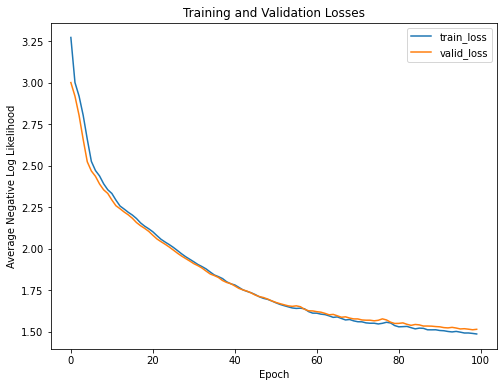

In [86]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history_df[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

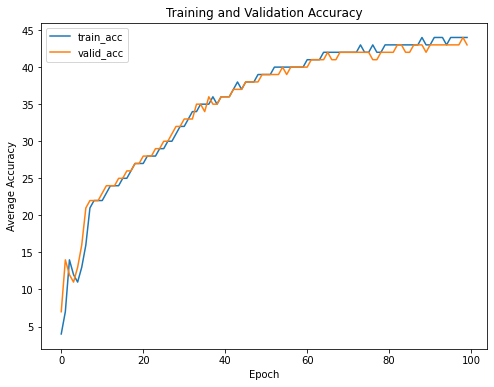

In [87]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
         history_df[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

## Optuna

In [40]:
import optuna

In [41]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())

[I 2022-04-08 19:21:45,143] A new study created in memory with name: no-name-b5c87aa4-2a41-4cab-a258-26004debf2bc


In [42]:
import math

layers_nodes = []
for layers in [2, 3, 4, 6, 8]:
    max = math.pow(2, 10) #1024
    #if layers > 8:
    #    max = math.pow(2, 11) #2048
    arr = [math.ceil(a) for a in np.random.uniform(30, max, layers)]
    arr.sort(reverse=True)
    layers_nodes.append(arr)
    arr = [math.ceil(a) for a in np.random.uniform(30, max, layers)]
    arr.sort(reverse=True)
    layers_nodes.append(arr)
layers_nodes

[[403, 376],
 [891, 494],
 [639, 606, 392],
 [807, 788, 653],
 [641, 607, 532, 404],
 [759, 747, 307, 158],
 [956, 919, 763, 711, 371, 120],
 [950, 842, 702, 544, 529, 498],
 [909, 776, 773, 658, 619, 400, 223, 155],
 [847, 817, 617, 594, 555, 510, 237, 218]]

In [43]:
class MulticlassClassification(nn.Module):

    def __init__(self, cat_size, num_col, output_size, layers, p=0.2):
        super(MulticlassClassification, self).__init__()
        self.all_embeddings = nn.ModuleList(
            [nn.Embedding(categories, size) for categories, size in cat_size]
        )
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_col)

        all_layers = []
        num_cat_col = sum(e.embedding_dim for e in self.all_embeddings)
        input_size = num_cat_col + num_col

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i, embedding in enumerate(self.all_embeddings):
            embeddings.append(embedding(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x



In [44]:
def build_model(layers_nodes, dropout):
    model = MulticlassClassification(categorical_embedding_sizes, train_num.shape[1], 20, layers_nodes, p=dropout).to(device)
    return model

In [45]:
def multi_acc(y_pred, y_test):
    acc = (torch.softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float( y_test.size(0) )
    
    #y_pred_loss = torch.log_softmax(y_pred, dim = 1)
    #_, y_pred_tags = torch.max(y_pred_loss, dim = 1)    
    
    #correct_pred = (y_pred_tags == y_test.float()
    #acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc.item()

In [46]:
from timeit import default_timer as timer

history = []

In [68]:
from torch import tensor 
multi_acc(tensor([[0, 0.3, -6, 1, 1.2]]), tensor([4]))

100.0

In [47]:
epochs = 100
overall_start = timer()

def train(model, optimizer):
    model.train()
    # Early stopping intialization
    epochs_no_improve = 0
    min_valid_loss = np.Inf
    min_valid_acc = 0
    
    criterion = nn.CrossEntropyLoss()

    for e in range(epochs):
        train_loss = 0.0
        train_acc = 0

        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        pred_train = model(train_cat, train_num)
        # Find the Loss
        loss = criterion(pred_train, y_train)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        # Calculation Acc
        train_acc = multi_acc(pred_train, y_train)

        valid_loss = 0.0
        valid_acc = 0 

        model.eval()     # Optional when not using Model Specific layer

        # Forward Pass
        pred_val = model(valid_cat, valid_num)
        # Find the Loss
        loss = criterion(pred_val, y_valid)
        # Calculate Loss
        valid_loss += loss.item()
        # Calculate Acc
        valid_acc = multi_acc(pred_val, y_valid)

        history.append([train_loss, valid_loss, train_acc, valid_acc])

        log = f'Epoch {e+1} | Training Loss: {train_loss} | Validation Loss: {valid_loss} | Train Acc: {train_acc} | Validation Acc: {valid_acc}'

        if min_valid_loss > valid_loss:
            log += (f' | Loss Decreased from ({min_valid_loss:.6f}) | Saving')
            min_valid_loss = valid_loss
            min_valid_acc = valid_acc
            
        
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model.pth')
            
        print(log, end='\r')

    total_time = timer() - overall_start
    print(f'\n{total_time:.2f} total seconds elapsed. {total_time / (epochs):.2f} seconds per epoch.\n')
    
    return min_valid_acc

In [48]:
def objective(trial):
    
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'optimizer': trial.suggest_categorical('optimizer', ["Adam", "RMSprop", "SGD"]),
        'layers_nodes': trial.suggest_categorical('layers_nodes', layers_nodes),
        'dropout': trial.suggest_categorical('dropout', [0.1, 0.2, 0.4]) 
    }
    print(params)
    
    model = build_model(params['layers_nodes'], params['dropout'])
    optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])
    accuracy = train(model, optimizer)
    
    del model
    torch.cuda.empty_cache()
    return accuracy

In [62]:
torch.cuda.empty_cache()
#del study
#del model
#del history

In [49]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [50]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

[I 2022-04-08 19:22:06,555] A new study created in memory with name: no-name-5529c440-6bbc-4a6d-88fd-e022a0451a7b


{'learning_rate': 0.09315699138091446, 'optimizer': 'SGD', 'layers_nodes': [847, 817, 617, 594, 555, 510, 237, 218], 'dropout': 0.2}


[I 2022-04-08 19:23:39,749] Trial 0 finished with value: 19.0 and parameters: {'learning_rate': 0.09315699138091446, 'optimizer': 'SGD', 'layers_nodes': [847, 817, 617, 594, 555, 510, 237, 218], 'dropout': 0.2}. Best is trial 0 with value: 19.0.


Epoch 100 | Training Loss: 2.4095537662506104 | Validation Loss: 2.4090030193328857 | Train Acc: 19.0 | Validation Acc: 19.0 | Loss Decreased from (2.409986) | Saving
101.77 total seconds elapsed. 1.02 seconds per epoch.

{'learning_rate': 0.021593924203574873, 'optimizer': 'RMSprop', 'layers_nodes': [807, 788, 653], 'dropout': 0.4}


[I 2022-04-08 19:24:28,763] Trial 1 finished with value: 20.0 and parameters: {'learning_rate': 0.021593924203574873, 'optimizer': 'RMSprop', 'layers_nodes': [807, 788, 653], 'dropout': 0.4}. Best is trial 1 with value: 20.0.


Epoch 100 | Training Loss: 3.4121501445770264 | Validation Loss: 7.43261194229126 | Train Acc: 19.0 | Validation Acc: 18.0
150.82 total seconds elapsed. 1.51 seconds per epoch.

{'learning_rate': 0.00016095472225497885, 'optimizer': 'RMSprop', 'layers_nodes': [891, 494], 'dropout': 0.1}


[I 2022-04-08 19:25:00,627] Trial 2 finished with value: 37.0 and parameters: {'learning_rate': 0.00016095472225497885, 'optimizer': 'RMSprop', 'layers_nodes': [891, 494], 'dropout': 0.1}. Best is trial 2 with value: 37.0.


Epoch 100 | Training Loss: 1.7311514616012573 | Validation Loss: 1.736311674118042 | Train Acc: 38.0 | Validation Acc: 37.0 | Loss Decreased from (1.739605) | Saving
182.71 total seconds elapsed. 1.83 seconds per epoch.

{'learning_rate': 0.0007811266637370114, 'optimizer': 'RMSprop', 'layers_nodes': [639, 606, 392], 'dropout': 0.4}


[I 2022-04-08 19:25:35,056] Trial 3 finished with value: 42.0 and parameters: {'learning_rate': 0.0007811266637370114, 'optimizer': 'RMSprop', 'layers_nodes': [639, 606, 392], 'dropout': 0.4}. Best is trial 3 with value: 42.0.


Epoch 100 | Training Loss: 1.532860279083252 | Validation Loss: 1.5510281324386597 | Train Acc: 41.0 | Validation Acc: 41.0
217.13 total seconds elapsed. 2.17 seconds per epoch.

{'learning_rate': 0.002950423407340727, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}


[I 2022-04-08 19:25:53,107] Trial 4 finished with value: 45.0 and parameters: {'learning_rate': 0.002950423407340727, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 1.3969227075576782 | Validation Loss: 1.4586560726165771 | Train Acc: 47.0 | Validation Acc: 45.0 | Loss Decreased from (1.460494) | Saving
235.20 total seconds elapsed. 2.35 seconds per epoch.

{'learning_rate': 8.080155519003505e-05, 'optimizer': 'SGD', 'layers_nodes': [641, 607, 532, 404], 'dropout': 0.1}


[I 2022-04-08 19:26:39,729] Trial 5 finished with value: 2.0 and parameters: {'learning_rate': 8.080155519003505e-05, 'optimizer': 'SGD', 'layers_nodes': [641, 607, 532, 404], 'dropout': 0.1}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 2.9927115440368652 | Validation Loss: 2.992738723754883 | Train Acc: 2.0 | Validation Acc: 2.0 | Loss Decreased from (2.992750) | Saving
281.80 total seconds elapsed. 2.82 seconds per epoch.

{'learning_rate': 4.586009021780525e-05, 'optimizer': 'RMSprop', 'layers_nodes': [909, 776, 773, 658, 619, 400, 223, 155], 'dropout': 0.1}


[I 2022-04-08 19:29:10,330] Trial 6 finished with value: 19.0 and parameters: {'learning_rate': 4.586009021780525e-05, 'optimizer': 'RMSprop', 'layers_nodes': [909, 776, 773, 658, 619, 400, 223, 155], 'dropout': 0.1}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 2.3198342323303223 | Validation Loss: 2.3205199241638184 | Train Acc: 19.0 | Validation Acc: 19.0 | Loss Decreased from (2.321456) | Saving
432.34 total seconds elapsed. 4.32 seconds per epoch.

{'learning_rate': 1.548709133204518e-05, 'optimizer': 'Adam', 'layers_nodes': [807, 788, 653], 'dropout': 0.4}


[I 2022-04-08 19:30:00,817] Trial 7 finished with value: 19.0 and parameters: {'learning_rate': 1.548709133204518e-05, 'optimizer': 'Adam', 'layers_nodes': [807, 788, 653], 'dropout': 0.4}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 2.4430112838745117 | Validation Loss: 2.4384925365448 | Train Acc: 19.0 | Validation Acc: 19.0 | Loss Decreased from (2.442707) | Saving
482.87 total seconds elapsed. 4.83 seconds per epoch.

{'learning_rate': 3.998201125083772e-05, 'optimizer': 'Adam', 'layers_nodes': [909, 776, 773, 658, 619, 400, 223, 155], 'dropout': 0.1}


[I 2022-04-08 19:32:55,977] Trial 8 finished with value: 19.0 and parameters: {'learning_rate': 3.998201125083772e-05, 'optimizer': 'Adam', 'layers_nodes': [909, 776, 773, 658, 619, 400, 223, 155], 'dropout': 0.1}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 2.7942848205566406 | Validation Loss: 2.7763516902923584 | Train Acc: 19.0 | Validation Acc: 19.0 | Loss Decreased from (2.795208) | Saving
657.97 total seconds elapsed. 6.58 seconds per epoch.

{'learning_rate': 0.00348267997195638, 'optimizer': 'RMSprop', 'layers_nodes': [950, 842, 702, 544, 529, 498], 'dropout': 0.1}


[I 2022-04-08 19:34:21,321] Trial 9 finished with value: 23.0 and parameters: {'learning_rate': 0.00348267997195638, 'optimizer': 'RMSprop', 'layers_nodes': [950, 842, 702, 544, 529, 498], 'dropout': 0.1}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 2.258314609527588 | Validation Loss: 2.2616305351257324 | Train Acc: 21.0 | Validation Acc: 22.0
743.34 total seconds elapsed. 7.43 seconds per epoch.

{'learning_rate': 0.002312796045250131, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}
Epoch 100 | Training Loss: 1.4118255376815796 | Validation Loss: 1.4625508785247803 | Train Acc: 47.0 | Validation Acc: 45.0| Loss Decreased from (1.464307) | Saving
761.68 total seconds elapsed. 7.62 seconds per epoch.



[I 2022-04-08 19:34:39,582] Trial 10 finished with value: 45.0 and parameters: {'learning_rate': 0.002312796045250131, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


{'learning_rate': 0.0024818864910090116, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}


[I 2022-04-08 19:34:57,925] Trial 11 finished with value: 45.0 and parameters: {'learning_rate': 0.0024818864910090116, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 1.4077154397964478 | Validation Loss: 1.4612956047058105 | Train Acc: 47.0 | Validation Acc: 45.0 | Loss Decreased from (1.463308) | Saving
780.02 total seconds elapsed. 7.80 seconds per epoch.

{'learning_rate': 0.0005536206922320194, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}
Epoch 100 | Training Loss: 1.6158332824707031 | Validation Loss: 1.625189185142517 | Train Acc: 41.0 | Validation Acc: 41.0 | Loss Decreased from (1.629491) | Saving
798.65 total seconds elapsed. 7.99 seconds per epoch.



[I 2022-04-08 19:35:16,561] Trial 12 finished with value: 41.0 and parameters: {'learning_rate': 0.0005536206922320194, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


{'learning_rate': 0.008605214285675135, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}
Epoch 100 | Training Loss: 1.324772834777832 | Validation Loss: 1.4819258451461792 | Train Acc: 49.0 | Validation Acc: 46.0Loss Decreased from (1.464150) | Savingngg
817.51 total seconds elapsed. 8.18 seconds per epoch.



[I 2022-04-08 19:35:35,416] Trial 13 finished with value: 45.0 and parameters: {'learning_rate': 0.008605214285675135, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


{'learning_rate': 0.00034214836707488136, 'optimizer': 'Adam', 'layers_nodes': [759, 747, 307, 158], 'dropout': 0.2}


[I 2022-04-08 19:36:20,561] Trial 14 finished with value: 39.0 and parameters: {'learning_rate': 0.00034214836707488136, 'optimizer': 'Adam', 'layers_nodes': [759, 747, 307, 158], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 1.669914722442627 | Validation Loss: 1.6749961376190186 | Train Acc: 39.0 | Validation Acc: 39.0 | Loss Decreased from (1.679184) | Saving
862.63 total seconds elapsed. 8.63 seconds per epoch.

{'learning_rate': 0.002353463731170624, 'optimizer': 'Adam', 'layers_nodes': [956, 919, 763, 711, 371, 120], 'dropout': 0.2}


[I 2022-04-08 19:37:45,391] Trial 15 finished with value: 42.0 and parameters: {'learning_rate': 0.002353463731170624, 'optimizer': 'Adam', 'layers_nodes': [956, 919, 763, 711, 371, 120], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 1.4894587993621826 | Validation Loss: 1.5412548780441284 | Train Acc: 43.0 | Validation Acc: 42.0
947.41 total seconds elapsed. 9.47 seconds per epoch.

{'learning_rate': 0.018875881908287775, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}
Epoch 100 | Training Loss: 1.3567239046096802 | Validation Loss: 1.5246714353561401 | Train Acc: 48.0 | Validation Acc: 45.0Loss Decreased from (1.495329) | Savinggg
965.98 total seconds elapsed. 9.66 seconds per epoch.



[I 2022-04-08 19:38:03,888] Trial 16 finished with value: 44.0 and parameters: {'learning_rate': 0.018875881908287775, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


{'learning_rate': 0.012464966152799307, 'optimizer': 'SGD', 'layers_nodes': [403, 376], 'dropout': 0.2}
Epoch 100 | Training Loss: 2.42118239402771 | Validation Loss: 2.420475482940674 | Train Acc: 19.0 | Validation Acc: 19.0 | Loss Decreased from (2.421704) | Savingng
984.28 total seconds elapsed. 9.84 seconds per epoch.



[I 2022-04-08 19:38:22,185] Trial 17 finished with value: 19.0 and parameters: {'learning_rate': 0.012464966152799307, 'optimizer': 'SGD', 'layers_nodes': [403, 376], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


{'learning_rate': 0.009089436734001737, 'optimizer': 'Adam', 'layers_nodes': [950, 842, 702, 544, 529, 498], 'dropout': 0.2}


[I 2022-04-08 19:40:36,288] Trial 18 finished with value: 41.0 and parameters: {'learning_rate': 0.009089436734001737, 'optimizer': 'Adam', 'layers_nodes': [950, 842, 702, 544, 529, 498], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 1.4970310926437378 | Validation Loss: 1.5707521438598633 | Train Acc: 43.0 | Validation Acc: 41.0
1118.30 total seconds elapsed. 11.18 seconds per epoch.

{'learning_rate': 0.06467723789644553, 'optimizer': 'Adam', 'layers_nodes': [641, 607, 532, 404], 'dropout': 0.2}


[I 2022-04-08 19:41:22,852] Trial 19 finished with value: 20.0 and parameters: {'learning_rate': 0.06467723789644553, 'optimizer': 'Adam', 'layers_nodes': [641, 607, 532, 404], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 2.331904888153076 | Validation Loss: 2.334521532058716 | Train Acc: 20.0 | Validation Acc: 20.0 | Loss Decreased from (2.335031) | Saving
1164.92 total seconds elapsed. 11.65 seconds per epoch.

{'learning_rate': 0.006900375792370578, 'optimizer': 'SGD', 'layers_nodes': [956, 919, 763, 711, 371, 120], 'dropout': 0.4}


[I 2022-04-08 19:42:46,954] Trial 20 finished with value: 19.0 and parameters: {'learning_rate': 0.006900375792370578, 'optimizer': 'SGD', 'layers_nodes': [956, 919, 763, 711, 371, 120], 'dropout': 0.4}. Best is trial 4 with value: 45.0.


Epoch 100 | Training Loss: 2.921908378601074 | Validation Loss: 2.921858310699463 | Train Acc: 19.0 | Validation Acc: 19.0 | Loss Decreased from (2.922510) | Saving
1248.98 total seconds elapsed. 12.49 seconds per epoch.

{'learning_rate': 0.0019690416853257965, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}
Epoch 100 | Training Loss: 1.4370849132537842 | Validation Loss: 1.4758613109588623 | Train Acc: 45.0 | Validation Acc: 44.0 | Loss Decreased from (1.481199) | Saving
1267.16 total seconds elapsed. 12.67 seconds per epoch.



[I 2022-04-08 19:43:05,071] Trial 21 finished with value: 44.0 and parameters: {'learning_rate': 0.0019690416853257965, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


{'learning_rate': 0.001164764828123635, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}
Epoch 100 | Training Loss: 1.4791252613067627 | Validation Loss: 1.5079963207244873 | Train Acc: 45.0 | Validation Acc: 44.0| Loss Decreased from (1.508208) | Saving
1285.40 total seconds elapsed. 12.85 seconds per epoch.



[I 2022-04-08 19:43:23,306] Trial 22 finished with value: 44.0 and parameters: {'learning_rate': 0.001164764828123635, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}. Best is trial 4 with value: 45.0.


{'learning_rate': 0.004429152471121006, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}


[I 2022-04-08 19:43:41,347] Trial 23 finished with value: 46.0 and parameters: {'learning_rate': 0.004429152471121006, 'optimizer': 'Adam', 'layers_nodes': [403, 376], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.3673508167266846 | Validation Loss: 1.4568480253219604 | Train Acc: 48.0 | Validation Acc: 46.0
1303.44 total seconds elapsed. 13.03 seconds per epoch.

{'learning_rate': 0.005387097002960565, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:44:13,118] Trial 24 finished with value: 46.0 and parameters: {'learning_rate': 0.005387097002960565, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.3380978107452393 | Validation Loss: 1.457889437675476 | Train Acc: 49.0 | Validation Acc: 46.0
1335.19 total seconds elapsed. 13.35 seconds per epoch.

{'learning_rate': 0.030352073167889335, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:44:44,648] Trial 25 finished with value: 43.0 and parameters: {'learning_rate': 0.030352073167889335, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.4075778722763062 | Validation Loss: 1.67375910282135 | Train Acc: 47.0 | Validation Acc: 44.0
1366.72 total seconds elapsed. 13.67 seconds per epoch.

{'learning_rate': 0.005687148302421807, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:45:16,352] Trial 26 finished with value: 46.0 and parameters: {'learning_rate': 0.005687148302421807, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.3376803398132324 | Validation Loss: 1.4624779224395752 | Train Acc: 49.0 | Validation Acc: 46.0
1398.43 total seconds elapsed. 13.98 seconds per epoch.

{'learning_rate': 0.0060278033611395115, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:45:48,385] Trial 27 finished with value: 46.0 and parameters: {'learning_rate': 0.0060278033611395115, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.3405851125717163 | Validation Loss: 1.4869776964187622 | Train Acc: 49.0 | Validation Acc: 45.0
1430.46 total seconds elapsed. 14.30 seconds per epoch.

{'learning_rate': 0.05404472453835725, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:46:19,619] Trial 28 finished with value: 22.0 and parameters: {'learning_rate': 0.05404472453835725, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 2.0073165893554688 | Validation Loss: 5.1993818283081055 | Train Acc: 29.0 | Validation Acc: 28.0
1461.69 total seconds elapsed. 14.62 seconds per epoch.

{'learning_rate': 0.0011044219597645714, 'optimizer': 'SGD', 'layers_nodes': [847, 817, 617, 594, 555, 510, 237, 218], 'dropout': 0.4}


[I 2022-04-08 19:47:53,278] Trial 29 finished with value: 0.0 and parameters: {'learning_rate': 0.0011044219597645714, 'optimizer': 'SGD', 'layers_nodes': [847, 817, 617, 594, 555, 510, 237, 218], 'dropout': 0.4}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 2.994797468185425 | Validation Loss: 2.9946277141571045 | Train Acc: 0.0 | Validation Acc: 0.0 | Loss Decreased from (2.994748) | Saving
1555.31 total seconds elapsed. 15.55 seconds per epoch.

{'learning_rate': 0.004658050581157989, 'optimizer': 'SGD', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:48:25,300] Trial 30 finished with value: 19.0 and parameters: {'learning_rate': 0.004658050581157989, 'optimizer': 'SGD', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 2.5264337062835693 | Validation Loss: 2.524702548980713 | Train Acc: 19.0 | Validation Acc: 19.0 | Loss Decreased from (2.527284) | Saving
1587.37 total seconds elapsed. 15.87 seconds per epoch.

{'learning_rate': 0.006106934269998413, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:48:57,122] Trial 31 finished with value: 45.0 and parameters: {'learning_rate': 0.006106934269998413, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.3393075466156006 | Validation Loss: 1.4686596393585205 | Train Acc: 49.0 | Validation Acc: 45.0
1619.20 total seconds elapsed. 16.19 seconds per epoch.

{'learning_rate': 0.017159635851085667, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:49:28,692] Trial 32 finished with value: 44.0 and parameters: {'learning_rate': 0.017159635851085667, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.3319319486618042 | Validation Loss: 1.592836856842041 | Train Acc: 49.0 | Validation Acc: 45.0
1650.77 total seconds elapsed. 16.51 seconds per epoch.

{'learning_rate': 0.026352165254667957, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:50:00,084] Trial 33 finished with value: 41.0 and parameters: {'learning_rate': 0.026352165254667957, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.4045685529708862 | Validation Loss: 1.9468032121658325 | Train Acc: 47.0 | Validation Acc: 44.0
1682.16 total seconds elapsed. 16.82 seconds per epoch.

{'learning_rate': 0.00446875857165897, 'optimizer': 'RMSprop', 'layers_nodes': [639, 606, 392], 'dropout': 0.2}


[I 2022-04-08 19:50:34,506] Trial 34 finished with value: 31.0 and parameters: {'learning_rate': 0.00446875857165897, 'optimizer': 'RMSprop', 'layers_nodes': [639, 606, 392], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.9655656814575195 | Validation Loss: 2.2059032917022705 | Train Acc: 29.0 | Validation Acc: 26.0
1716.58 total seconds elapsed. 17.17 seconds per epoch.

{'learning_rate': 0.012143466527729595, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.4}


[I 2022-04-08 19:51:06,110] Trial 35 finished with value: 45.0 and parameters: {'learning_rate': 0.012143466527729595, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.4}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.3247734308242798 | Validation Loss: 1.5169494152069092 | Train Acc: 49.0 | Validation Acc: 45.0
1748.19 total seconds elapsed. 17.48 seconds per epoch.

{'learning_rate': 0.0016172133497549604, 'optimizer': 'Adam', 'layers_nodes': [759, 747, 307, 158], 'dropout': 0.2}


[I 2022-04-08 19:51:50,847] Trial 36 finished with value: 44.0 and parameters: {'learning_rate': 0.0016172133497549604, 'optimizer': 'Adam', 'layers_nodes': [759, 747, 307, 158], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.449017882347107 | Validation Loss: 1.4805160760879517 | Train Acc: 46.0 | Validation Acc: 44.0 | Loss Decreased from (1.482553) | Saving
1792.91 total seconds elapsed. 17.93 seconds per epoch.

{'learning_rate': 0.0004913914270841639, 'optimizer': 'RMSprop', 'layers_nodes': [847, 817, 617, 594, 555, 510, 237, 218], 'dropout': 0.1}


[I 2022-04-08 19:53:22,492] Trial 37 finished with value: 24.0 and parameters: {'learning_rate': 0.0004913914270841639, 'optimizer': 'RMSprop', 'layers_nodes': [847, 817, 617, 594, 555, 510, 237, 218], 'dropout': 0.1}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 2.3752098083496094 | Validation Loss: 2.2993581295013428 | Train Acc: 18.0 | Validation Acc: 15.0
1884.51 total seconds elapsed. 18.85 seconds per epoch.

{'learning_rate': 0.032416941639632886, 'optimizer': 'Adam', 'layers_nodes': [807, 788, 653], 'dropout': 0.2}


[I 2022-04-08 19:54:11,369] Trial 38 finished with value: 32.0 and parameters: {'learning_rate': 0.032416941639632886, 'optimizer': 'Adam', 'layers_nodes': [807, 788, 653], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.7677401304244995 | Validation Loss: 3.4895846843719482 | Train Acc: 36.0 | Validation Acc: 34.0
1933.42 total seconds elapsed. 19.33 seconds per epoch.

{'learning_rate': 0.0001777192342697707, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.4}


[I 2022-04-08 19:54:43,919] Trial 39 finished with value: 36.0 and parameters: {'learning_rate': 0.0001777192342697707, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.4}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.8284214735031128 | Validation Loss: 1.8305184841156006 | Train Acc: 36.0 | Validation Acc: 36.0 | Loss Decreased from (1.835231) | Saving
1966.00 total seconds elapsed. 19.66 seconds per epoch.

{'learning_rate': 0.004551240863377107, 'optimizer': 'RMSprop', 'layers_nodes': [639, 606, 392], 'dropout': 0.1}


[I 2022-04-08 19:55:18,319] Trial 40 finished with value: 35.0 and parameters: {'learning_rate': 0.004551240863377107, 'optimizer': 'RMSprop', 'layers_nodes': [639, 606, 392], 'dropout': 0.1}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.818167805671692 | Validation Loss: 1.8159539699554443 | Train Acc: 33.0 | Validation Acc: 35.0 | Loss Decreased from (1.848241) | Saving
2000.39 total seconds elapsed. 20.00 seconds per epoch.

{'learning_rate': 0.006490102802605996, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:55:50,083] Trial 41 finished with value: 45.0 and parameters: {'learning_rate': 0.006490102802605996, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.340855360031128 | Validation Loss: 1.4865468740463257 | Train Acc: 49.0 | Validation Acc: 45.0
2032.16 total seconds elapsed. 20.32 seconds per epoch.

{'learning_rate': 0.011929244839570424, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:56:21,687] Trial 42 finished with value: 45.0 and parameters: {'learning_rate': 0.011929244839570424, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.3181049823760986 | Validation Loss: 1.5198849439620972 | Train Acc: 50.0 | Validation Acc: 45.0
2063.76 total seconds elapsed. 20.64 seconds per epoch.

{'learning_rate': 0.012603855917836202, 'optimizer': 'Adam', 'layers_nodes': [909, 776, 773, 658, 619, 400, 223, 155], 'dropout': 0.2}


[I 2022-04-08 19:58:51,201] Trial 43 finished with value: 34.0 and parameters: {'learning_rate': 0.012603855917836202, 'optimizer': 'Adam', 'layers_nodes': [909, 776, 773, 658, 619, 400, 223, 155], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.740824818611145 | Validation Loss: 1.7438929080963135 | Train Acc: 34.0 | Validation Acc: 34.0 | Loss Decreased from (1.765842) | Saving
2213.21 total seconds elapsed. 22.13 seconds per epoch.

{'learning_rate': 0.004058387081396732, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 19:59:24,158] Trial 44 finished with value: 46.0 and parameters: {'learning_rate': 0.004058387081396732, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.3589918613433838 | Validation Loss: 1.4498504400253296 | Train Acc: 48.0 | Validation Acc: 46.0
2246.24 total seconds elapsed. 22.46 seconds per epoch.

{'learning_rate': 0.003269900563667534, 'optimizer': 'Adam', 'layers_nodes': [641, 607, 532, 404], 'dropout': 0.2}


[I 2022-04-08 20:00:10,978] Trial 45 finished with value: 45.0 and parameters: {'learning_rate': 0.003269900563667534, 'optimizer': 'Adam', 'layers_nodes': [641, 607, 532, 404], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.3913904428482056 | Validation Loss: 1.4633911848068237 | Train Acc: 47.0 | Validation Acc: 45.0
2293.05 total seconds elapsed. 22.93 seconds per epoch.

{'learning_rate': 0.001550675289996345, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.1}


[I 2022-04-08 20:00:42,857] Trial 46 finished with value: 45.0 and parameters: {'learning_rate': 0.001550675289996345, 'optimizer': 'Adam', 'layers_nodes': [891, 494], 'dropout': 0.1}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.4572148323059082 | Validation Loss: 1.5081770420074463 | Train Acc: 45.0 | Validation Acc: 44.0
2324.94 total seconds elapsed. 23.25 seconds per epoch.

{'learning_rate': 0.00069647324487214, 'optimizer': 'Adam', 'layers_nodes': [807, 788, 653], 'dropout': 0.2}


[I 2022-04-08 20:01:32,980] Trial 47 finished with value: 43.0 and parameters: {'learning_rate': 0.00069647324487214, 'optimizer': 'Adam', 'layers_nodes': [807, 788, 653], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 1.5029765367507935 | Validation Loss: 1.5262469053268433 | Train Acc: 43.0 | Validation Acc: 43.0
2375.03 total seconds elapsed. 23.75 seconds per epoch.

{'learning_rate': 0.0030433600885631964, 'optimizer': 'RMSprop', 'layers_nodes': [950, 842, 702, 544, 529, 498], 'dropout': 0.2}


[I 2022-04-08 20:03:36,627] Trial 48 finished with value: 20.0 and parameters: {'learning_rate': 0.0030433600885631964, 'optimizer': 'RMSprop', 'layers_nodes': [950, 842, 702, 544, 529, 498], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 2.320071220397949 | Validation Loss: 2.320342779159546 | Train Acc: 21.0 | Validation Acc: 20.0 | Loss Decreased from (2.323673) | Saving
2498.64 total seconds elapsed. 24.99 seconds per epoch.

{'learning_rate': 0.004402406922060402, 'optimizer': 'SGD', 'layers_nodes': [891, 494], 'dropout': 0.2}


[I 2022-04-08 20:04:09,083] Trial 49 finished with value: 19.0 and parameters: {'learning_rate': 0.004402406922060402, 'optimizer': 'SGD', 'layers_nodes': [891, 494], 'dropout': 0.2}. Best is trial 23 with value: 46.0.


Epoch 100 | Training Loss: 2.5329675674438477 | Validation Loss: 2.5312178134918213 | Train Acc: 19.0 | Validation Acc: 19.0 | Loss Decreased from (2.533951) | Saving
2531.16 total seconds elapsed. 25.31 seconds per epoch.



In [51]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.004429152471121006
optimizer: Adam
layers_nodes: [403, 376]
dropout: 0.2


In [53]:
optuna.visualization.plot_optimization_history(study)

In [55]:
optuna.visualization.plot_param_importances(study)